<a href="https://colab.research.google.com/github/thekkanathashish95/Projects/blob/master/Market_Analytics_Sample_Pet_Store.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Sample Pet Store Dataset - Market Analytics**



##Data Exploration

####Importing Required Libraries

In [ ]:
pip install Lifetimes==0.10.1

     |████████████████████████████████| 583kB 2.7MB/s 


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt 
from datetime import timedelta
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from keras.models import Sequential # Allows creation of neural network object represented in a sequence of layers
from keras.layers import Dense #Allows us to add the output layer
from keras.layers import LSTM # Allows addition of LSTM layers
from keras.layers import Dropout #Allows addition of dropout regularization
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report,confusion_matrix
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from lifetimes.utils import *
from lifetimes import BetaGeoFitter
from lifetimes.plotting import plot_probability_alive_matrix, plot_frequency_recency_matrix
from lifetimes.generate_data import beta_geometric_nbd_model
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases, plot_period_transactions,plot_history_alive


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


####Reading the Dataset & Primary Analysis

In [ ]:
pets=pd.read_excel("Pets World - Transaction Data.xlsx")
pw=pets

**Missing Data**.

Brand=27917 |
Category=17080 |
Customer=4457

In [ ]:
pets.describe()

,Transaction ID,System ID,Qty,Retail,Sub Total,Discount,Tax Collected,Tax,Total Collected,Cost
count,2.376030e+05,2.376030e+05,237603.000000,237603.000000,237603.000000,237603.000000,237603.000000,237603.000000,237603.000000,237603.000000
mean,5.457959e+05,1.950368e+11,1.747078,17.566334,20.781732,-1.483389,1.509371,0.077774,20.768084,12.694590
std,2.477716e+05,5.402209e+10,2.575230,22.941247,26.142264,4.339356,1.897888,0.007087,26.892762,17.398503
min,1.467000e+04,0.000000e+00,-50.000000,-566.000000,-566.000000,-155.960000,-43.865000,0.000000,-609.860000,-243.000000
25%,3.406310e+05,2.100000e+11,1.000000,2.790000,4.990000,-1.330000,0.370000,0.077500,5.150000,2.220000
50%,5.472230e+05,2.100000e+11,1.000000,9.990000,12.160000,0.000000,0.910000,0.077500,12.610000,6.190000
75%,7.650945e+05,2.100000e+11,2.000000,22.500000,27.980000,0.000000,2.000000,0.080000,27.890000,16.320000
max,1.000029e+06,2.100000e+11,215.000000,848.940000,1469.790000,54.000000,113.908000,0.102500,1583.700000,841.050000


####Taking care of missing data

In [ ]:
pets["Brand"].fillna("Not Defined", inplace=True)
pets["Category"].fillna("Not Defined", inplace=True)
pets["Customer"].fillna("Unknown", inplace=True)

##Descriptive Analysis

In [ ]:
pets.columns

Index(['Transaction ID', 'Date', 'Shop', 'System ID', 'Description', 'Brand',
       'Category', 'Qty', 'Retail', 'Sub Total', 'Discount', 'Tax Collected',
       'Tax', 'Total Collected', 'Cost', 'Customer', 'Employee'],
      dtype='object')

In [ ]:
pets["Shop"].value_counts()

Pets World    237603
Name: Shop, dtype: int64

###Brands

In [ ]:
sales=pets[pets["Qty"]>0]
sales["Profit"]=sales["Total Collected"]-sales["Cost"]

####How many brands are associated with Pets World?

In [ ]:
pets["Brand"].value_counts()

Not Defined           27917
Naked                 19912
Weruva                19216
Northwest Naturals    10706
Merrick Pet Foods      9450
                      ...  
Cheese Please             1
2 Hounds Design           1
Flexi                     1
Prime Taste Treats        1
OllyDog                   1
Name: Brand, Length: 238, dtype: int64

In [ ]:
pets["Brand"].nunique()

238

There are a total of 238 different brands of goods sold by Pets World

####Top 10 Brands being Sold

Not Defined           27917
Naked                 19912
Weruva                19216
Northwest Naturals    10706
Merrick Pet Foods      9450
Fromm                  8658
Taste of the Wild      7124
Earth Animal           7056
Zignature              6616
RedBarn                5685
Name: Brand, dtype: int64


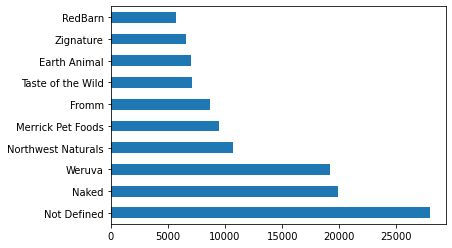

In [ ]:
top_10_brands=pw["Brand"].value_counts().head(10)
top_10_brands.plot.barh()
print(top_10_brands)

As can be observed from the table and the graph, Naked, Weruva and Northwest Naturals are the top selling brands respectively.

In [ ]:
pets["Category"].head()

0                     Dog --> Toys
1                     Dog --> Toys
2        Dog--> Treats --> Biscuit
3        Dog--> Treats --> Biscuit
4    Dog--> Raw Frozen --> Poultry
Name: Category, dtype: object

In [ ]:
sales.columns

Index(['Transaction ID', 'Date', 'Shop', 'System ID', 'Description', 'Brand',
       'Category', 'Qty', 'Retail', 'Sub Total', 'Discount', 'Tax Collected',
       'Tax', 'Total Collected', 'Cost', 'Customer', 'Employee', 'Profit'],
      dtype='object')

####Top Brands based on Revenue Generation

                Brand  Total Collected
0               Naked        617471.05
1               Fromm        304584.17
2  Northwest Naturals        295444.68
3           Petcurean        275008.33
4   Taste of the Wild        263834.37
5              Orijen        257631.61
6         Not Defined        241722.26
7           Zignature        217156.78
8               Acana        158959.48
9         Small Batch        132737.94


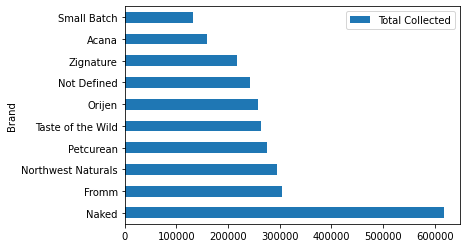

In [ ]:
br=sales.groupby("Brand")["Total Collected"].sum().sort_values(ascending=False).reset_index().head(10)
print(br)
br.plot.barh(x="Brand",y="Total Collected")

As can be observed, Naked is the brand with best revenue generation

####Top Brands based on profit Generation

                Brand     Profit
0               Naked  282680.52
1  Northwest Naturals  117364.63
2         Not Defined  116891.79
3               Fromm  112931.30
4           Petcurean   93212.19
5              Orijen   87234.97
6   Taste of the Wild   84968.58
7           Zignature   81905.62
8               Acana   53403.88
9         Small Batch   47346.22


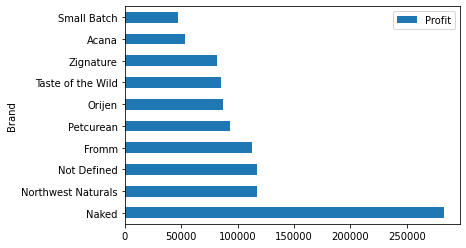

In [ ]:
bp=sales.groupby("Brand")["Profit"].sum().sort_values(ascending=False).reset_index().head(10)
print(bp)
bp.plot.barh(x="Brand",y="Profit")

As can be observed, there are considerable profit generation from the tab "Not Defined", which doesnt appear in the list of top 10 brands in terms of revenue generation. This means that profit generated from these unbranded products are high enough compared to their branded counterparts. This helps them to rank 3rd in profit contribution

###Products

####Finding out the different categories of products being sold

In [ ]:
sales=pets[pets["Qty"]>0]
sales.shape

(230941, 17)

In [ ]:
#Splitting categories column into subcategories

new = pets["Category"].str.split("--> ", n = 1, expand = True) 

In [ ]:
pets["cat"]=new[0]

In [ ]:
new.head()

,0,1
0,Dog,Toys
1,Dog,Toys
2,Dog,Treats --> Biscuit
3,Dog,Treats --> Biscuit
4,Dog,Raw Frozen --> Poultry


In [ ]:
temp=new[1].str.split(" --> ", n=1, expand=True)
temp

,0,1
0,Toys,None
1,Toys,None
2,Treats,Biscuit
3,Treats,Biscuit
4,Raw Frozen,Poultry
...,...,...
237598,Wet Food,Poultry
237599,Wet Food,Fish
237600,Wet Food,Poultry
237601,Food Toppers & Broths,Broths


In [ ]:
pets["super_sub_cat"]=temp[1]
pets["sub_cat"]=temp[0]

In [ ]:
len(pets["cat"])

237603

In [ ]:
pets.head()

,Transaction ID,Date,Shop,System ID,Description,Brand,Category,Qty,Retail,Sub Total,Discount,Tax Collected,Tax,Total Collected,Cost,Customer,Employee,cat,super_sub_cat,sub_cat
0,14670,2014-07-01 07:00:00+00:00,Pets World,210000002077,Kong Squeezz Jels Hippo MD ** ARCHIVED **,Not Defined,Dog --> Toys,1,5.99,5.99,0.0,0.48,0.08,6.47,3.02,Thomas John,None,Dog,None,Toys
1,14676,2014-07-01 07:00:00+00:00,Pets World,210000002077,Kong Squeezz Jels Hippo MD ** ARCHIVED **,Not Defined,Dog --> Toys,-1,5.99,5.99,0.0,0.48,0.08,6.47,3.02,Thomas John,None,Dog,None,Toys
2,14868,2014-07-02 07:00:00+00:00,Pets World,210000002043,Blue Buffalo Health Bars Baked with Banana & Y...,Blue Buffalo,Dog--> Treats --> Biscuit,-1,6.99,6.99,0.0,0.56,0.08,7.55,3.58,Jasmin Parson,None,Dog,Biscuit,Treats
3,14850,2014-07-02 07:00:00+00:00,Pets World,210000002043,Blue Buffalo Health Bars Baked with Banana & Y...,Blue Buffalo,Dog--> Treats --> Biscuit,1,6.99,6.99,0.0,0.56,0.08,7.55,3.58,Jasmin Parson,None,Dog,Biscuit,Treats
4,14790,2014-07-02 07:00:00+00:00,Pets World,210000001779,Nature's Variety Instinct Raw Signature Grain-...,Nature's Variety,Dog--> Raw Frozen --> Poultry,1,14.99,14.99,0.0,1.20,0.08,16.19,11.75,Tammi Wilson,None,Dog,Poultry,Raw Frozen


In [ ]:
for i in range(0,237603):
  if (pets["cat"][i]=="Dog "):
    pets["cat"][i]="Dog"

cat
Dog            293010
Cat            105637
Not Defined     16464
Name: Qty, dtype: int64


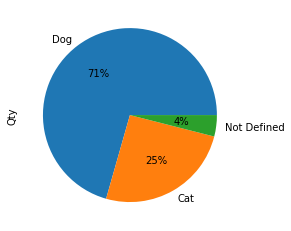

In [ ]:
categ=pets.groupby("cat")["Qty"].sum().sort_values(ascending=False)
categ.plot.pie(autopct='%1.0f%%')
print(categ)

As can be observed, most of the products sold by Pet world are for Dogs.

####Finding the top 10 Most sold subcategories of products

In [ ]:
sales=pets[pets["Qty"]>0]
sales.shape

(230941, 20)

cat  sub_cat            
Dog  Dry Food               90996
Cat  Wet Food               87613
Dog  Treats                 75881
     Wet Food               74084
     Raw Frozen             27154
     Raw Dried Food         16740
Cat  Dry Food               10377
Dog  Health and Grooming     6213
Cat  Raw Frozen              5490
Dog  Toys                    3563
Name: Qty, dtype: int64


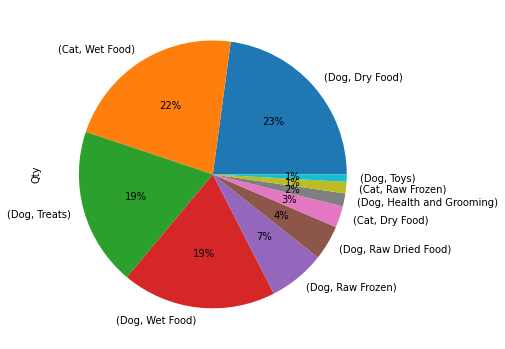

In [ ]:
sub_categ=sales.groupby(["cat","sub_cat"])["Qty"].sum().sort_values(ascending=False).head(10)
sub_categ.plot.pie(autopct='%1.0f%%', figsize=(6,8))
print(sub_categ)

These are the top 10 most sold subcategories of products

####Finding the top 10 most sold product super sub categories

cat  sub_cat   super_sub_cat  
Cat  Wet Food  Fish               43040
               Poultry            38617
Dog  Wet Food  Poultry            37368
     Dry Food  Poultry            37195
               Meat               29401
     Treats    Jerky              27114
               Bones & Bullies    25177
     Wet Food  Meat               21825
     Dry Food  Fish               18019
     Treats    Biscuit            12246
Name: Qty, dtype: int64


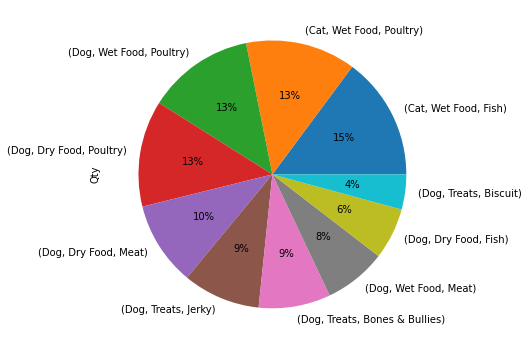

In [ ]:
super_sub_categ=sales.groupby(["cat","sub_cat","super_sub_cat"])["Qty"].sum().sort_values(ascending=False).head(10)
super_sub_categ.plot.pie(autopct='%1.0f%%', figsize=(6,8))
print(super_sub_categ)

####Top 10 most sold products

In [ ]:
pets.columns

Index(['Transaction ID', 'Date', 'Shop', 'System ID', 'Description', 'Brand',
       'Category', 'Qty', 'Retail', 'Sub Total', 'Discount', 'Tax Collected',
       'Tax', 'Total Collected', 'Cost', 'Customer', 'Employee', 'cat',
       'super_sub_cat', 'sub_cat'],
      dtype='object')

Description
Naked DOG Chicken Grain-Free Dry Dog Food By the Pound                                     11896
Naked DOG Lamb and Brown Rice Dry Dog Food By the Pound                                     9943
Promo code: None                                                                            9398
Naked DOG Beef Grain-Free Potato-Free Dry Dog Food By the Pound                             8804
Naked DOG Salmon Grain-Free Potato-Free Dry Dog Food By the Pound                           7283
Weruva Grain-Free Mideast Feast with Grilled Tilapia in Gravy Canned Cat Food 5.5z          5720
Naked DOG Turkey Grain-Free Potato-Free Dry Dog Food By the Pound                           5582
Weruva Grain-Free Paw Lickin' Chicken in Gravy Canned Cat Food 5.5z                         3843
Earthborn Holistic Chicken Catcciatori Grain-Free Natural Canned Cat & Kitten Food 5.5z     3395
Promo code: iruffyou                                                                        3176
Name: Qty, dtype: 

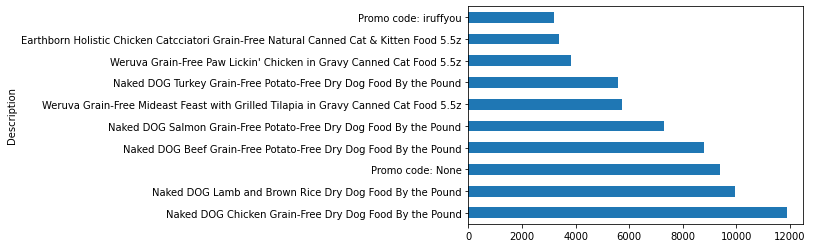

In [ ]:
top_products=sales.groupby("Description")["Qty"].sum().sort_values(ascending=False).head(10)
top_products.plot.barh()
print(top_products)

####Understanding the distribution of sales for the products sold

In [ ]:
top_products_d=sales.groupby("Description")["Qty"].sum().sort_values(ascending=False).reset_index()
top_products_d.head(2100)

,Description,Qty
0,Naked DOG Chicken Grain-Free Dry Dog Food By t...,11896
1,Naked DOG Lamb and Brown Rice Dry Dog Food By ...,9943
2,Promo code: None,9398
3,Naked DOG Beef Grain-Free Potato-Free Dry Dog ...,8804
4,Naked DOG Salmon Grain-Free Potato-Free Dry Do...,7283
...,...,...
2095,Weruva Paw Lickin Chicken Dogs & Cats Treats 1...,13
2096,ZiwiPeak Cat Grain-Free Venison Air-Dried Cat ...,13
2097,Zignature Grain-Free Turkey Limited Ingredient...,13
2098,Vital Essentials Vital Cat - Grain-Free Turkey...,13


There are a total of 4267 different products. **Out of the 4267 products more than half of it is sold less than 13 times in 5 years.**

####Revenue Generated per product category

In [ ]:
pets.columns

Index(['Transaction ID', 'Date', 'Shop', 'System ID', 'Description', 'Brand',
       'Category', 'Qty', 'Retail', 'Sub Total', 'Discount', 'Tax Collected',
       'Tax', 'Total Collected', 'Cost', 'Customer', 'Employee', 'cat',
       'super_sub_cat', 'sub_cat'],
      dtype='object')

In [ ]:
rev_cat=sales.groupby(["Description","Retail"])["Qty"].sum().sort_values(ascending=False).reset_index()
rev_cat.head()

,Description,Retail,Qty
0,Naked DOG Chicken Grain-Free Dry Dog Food By t...,2.50,6088
1,Naked DOG Lamb and Brown Rice Dry Dog Food By ...,2.25,5708
2,Promo code: None,10.00,3931
3,Naked DOG Salmon Grain-Free Potato-Free Dry Do...,2.99,3653
4,Naked DOG Beef Grain-Free Potato-Free Dry Dog ...,3.19,3500


####How many unique products does Pets World sell?

In [ ]:
pets["Description"].nunique()

4267

There are 4267 unique products being sold by Pets World

####How many Archived products does Pets World have?

In [ ]:
arch=pets.groupby("Description")["Transaction ID"].count().reset_index()
arch.head()

,Description,Transaction ID
0,"2 Hounds Design Dog Harness, Black, 1"" Medium ...",1
1,3M PET HAIR REMOVAL BRUSH ** ARCHIVED **,6
2,3M PET HAIR REMOVAL TOOL ** ARCHIVED **,2
3,3M PET HAIR REMOVAL TOOL REFILL ** ARCHIVED **,2
4,3M PET HAIR ROLLER BONUS 3PK ** ARCHIVED **,4


In [ ]:
temp=arch[arch["Description"].str.contains("ARCHIVED")]

In [ ]:
temp["Description"].count()

1037

Out of the 4267 unique products, 1037 are archived. Archived products are products that are no longer in the market

####Top 10 products based on Revenue Generation

In [ ]:
sales.columns

Index(['Transaction ID', 'Date', 'Shop', 'System ID', 'Description', 'Brand',
       'Category', 'Qty', 'Retail', 'Sub Total', 'Discount', 'Tax Collected',
       'Tax', 'Total Collected', 'Cost', 'Customer', 'Employee', 'cat',
       'super_sub_cat', 'sub_cat'],
      dtype='object')

                                          Description  Total Collected
0                                    Promo code: None        141568.50
1    Naked DOG Lamb and Brown Rice Dry Dog Food 50lbs         88607.51
2   Naked DOG Salmon Grain-Free Potato-Free Dry Do...         74956.96
3   Naked DOG Beef Grain-Free Potato-Free Dry Dog ...         72696.33
4     Naked DOG Chicken Grain-Free Dry Dog Food 50lbs         72345.48
5   Taste of the Wild High Prairie Dry Dog Food 28lbs         54512.10
6   Naked DOG Turkey Grain-Free Potato-Free Dry Do...         42948.22
7   Taste of the Wild Pacific Stream Dry Dog Food ...         37008.41
8   Taste of the Wild Sierra Mountain Dry Dog Food...         34270.31
9   Orijen Dog Six Fish Grain-Free Formula Dry Dog...         33778.45
10     Orijen Dog Adult Grain-Free Dry Dog Food 25lbs         32469.84
11  Naked DOG Chicken Grain-Free Dry Dog Food By t...         32453.54


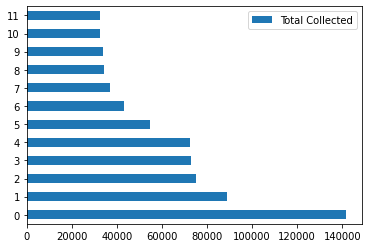

In [ ]:
top10pro=sales.groupby("Description")["Total Collected"].sum().sort_values(ascending=False).reset_index().head(12)
print(top10pro)
top10pro.plot.barh()


####Top 10 product categories based on revenue generation

           cat  Total Collected
0          Dog       4381417.39
1          Cat        490980.05
2  Not Defined         59470.55


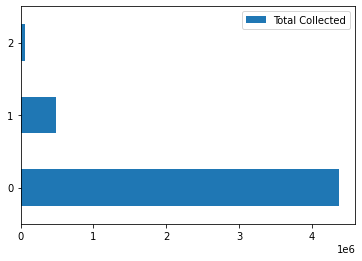

In [ ]:
top10cat=sales.groupby("cat")["Total Collected"].sum().sort_values(ascending=False).reset_index().head(12)
print(top10cat)
top10cat.plot.barh()

Above 80% of overall contribution to revenue are from the category of Dogs

####Top 10 subcategories based on Revenue Generation

In [ ]:
sales.columns

Index(['Transaction ID', 'Date', 'Shop', 'System ID', 'Description', 'Brand',
       'Category', 'Qty', 'Retail', 'Sub Total', 'Discount', 'Tax Collected',
       'Tax', 'Total Collected', 'Cost', 'Customer', 'Employee', 'cat',
       'super_sub_cat', 'sub_cat'],
      dtype='object')

                         sub_cat  Total Collected
0                       Dry Food       2536993.19
1                     Raw Frozen        696409.09
2                         Treats        559255.44
3                 Raw Dried Food        431730.07
4                       Wet Food        376954.84
5            Health and Grooming        144473.05
6                           Toys         42597.97
7               Waste Management         28368.34
8   Collars, Leashes & Harnesses         24463.64
9          Food Toppers & Broths         15609.90
10               Bowls & Feeders          6318.96
11              Active Lifestyle          2900.91


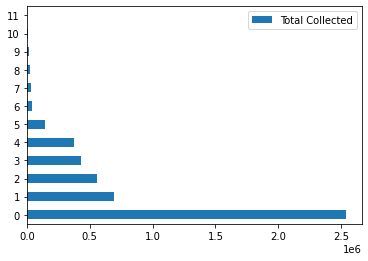

In [ ]:
top10scat=sales.groupby("sub_cat")["Total Collected"].sum().sort_values(ascending=False).reset_index().head(12)
print(top10scat)
top10scat.plot.barh()

Dry Food is the most revenue generating product sub category

####Most revenue Generating Super Sub categories

      super_sub_cat  Total Collected
0           Poultry       1725107.82
1              Meat       1061186.93
2              Fish        732019.31
3            Exotic        382411.79
4             Jerky        217674.51
5   Bones & Bullies        131913.35
6    Bones & Treats         78659.27
7           Biscuit         66588.63
8        Vegetarian         62702.07
9        Soft Chewy         57164.97
10           Dental         53155.22
11      Supplements         51644.36


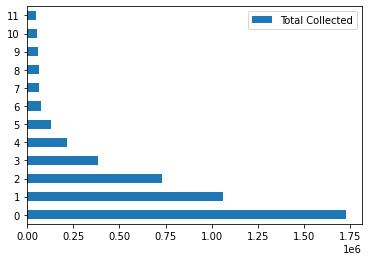

In [ ]:
top10sscat=sales.groupby("super_sub_cat")["Total Collected"].sum().sort_values(ascending=False).reset_index().head(12)
print(top10sscat)
top10sscat.plot.barh()

Poultry heads over Meat and Fish as the most consumed pet food sub category combining pet food for all kinds of pets


####Products with highest Tax

In [ ]:
sales.columns

Index(['Transaction ID', 'Date', 'Shop', 'System ID', 'Description', 'Brand',
       'Category', 'Qty', 'Retail', 'Sub Total', 'Discount', 'Tax Collected',
       'Tax', 'Total Collected', 'Cost', 'Customer', 'Employee', 'cat',
       'super_sub_cat', 'sub_cat'],
      dtype='object')

In [ ]:
tax_p=sales.groupby("Description")["Tax Collected"].sum().sort_values(ascending = True).head(10)
print(tax_p)

Description
Promo code: iruffyou              -1230.018
Promo code: WELCOME                -502.200
OOPs Item                          -353.692
Promo code: COMEBACK               -223.975
Promo code: new pro club member    -148.837
Promo code: THANKS                 -114.700
Promo code: holidays               -106.904
Promo code: tellafriend             -76.725
Promo code: soeasy                  -55.800
Promo code: RAMS                    -55.025
Name: Tax Collected, dtype: float64


As can be observed, OOPs Item must be for Tax Adjustment purpose

In [ ]:
tax_p=sales.groupby("Description")["Tax Collected"].mean().sort_values(ascending = False).head(10)
print(tax_p)

Description
Naked Whole Fish Stix Dog Treats BULK BOX ** ARCHIVED **                                                        31.000000
Weruva Caloric Harmony Chicken Dinner with Pumpkin Dry Dog Food 24lbs ** ARCHIVED **                            25.730000
Naked DOG Raw Beef Grain-Free Freeze Dried Dog Food 30lbs                                                       19.553083
Naked DOG Raw Turkey Grain-Free Freeze Dried Dog Food 30lbs                                                     18.394462
Naked DOG Raw Lamb Grain-Free Freeze Dried Dog Food 30lbs                                                       17.980000
NutriSource Prairie Select Grain-Free Canned Dog Food 13z, 12 Unit CASE                                         16.250000
Naked DOG Raw Veggie Mix Grain-Free Freeze Dried Dog Food 30lbs                                                 15.571667
Canine Caviar Limited Ingredient Diet Open Sky Holistic Entree Grain-Free Dry Dog Food 24lbs  ** ARCHIVED **    14.720000
Answers Deta

Naked DOG Raw Beef Grain-Free Freeze Dried Dog Food 30lbs is the product with max Tax collected on an average

In [ ]:
sales.columns

Index(['Transaction ID', 'Date', 'Shop', 'System ID', 'Description', 'Brand',
       'Category', 'Qty', 'Retail', 'Sub Total', 'Discount', 'Tax Collected',
       'Tax', 'Total Collected', 'Cost', 'Customer', 'Employee', 'cat',
       'super_sub_cat', 'sub_cat'],
      dtype='object')

####Products with Highest Overall Discount

In [ ]:
dis_p=sales.groupby("Description")["Discount"].sum().sort_values(ascending = True).head(10)
print(dis_p)

Description
Manufacturer Coupon                                          -35277.33
Promo code: iruffyou                                         -15880.00
Promo code: WELCOME                                           -6480.00
Naked DOG Lamb and Brown Rice Dry Dog Food 50lbs              -6190.22
Naked DOG Salmon Grain-Free Potato-Free Dry Dog Food 50lbs    -4803.22
Naked DOG Beef Grain-Free Potato-Free Dry Dog Food 50lbs      -4634.95
Naked DOG Chicken Grain-Free Dry Dog Food 50lbs               -4175.72
Promo code: COMEBACK                                          -2890.00
Naked DOG Chicken Grain-Free Dry Dog Food By the Pound        -2582.35
Taste of the Wild High Prairie Dry Dog Food 28lbs             -2544.34
Name: Discount, dtype: float64


Naked DOG Lamb and Brown Rice Dry Dog Food 50lbs is the product with highest discount. Also, discount in the form of manufacturer coupon is widely used across products

###Transactions

####Number of Unique Transactions over the 5 years

In [ ]:
x=pets["Transaction ID"].nunique()

In [ ]:
y=pets["Transaction ID"].count()

In [ ]:
y-x

132880

In [ ]:
print("Number of unique transactions over the 5 years: ",x)

Number of unique transactions over the 5 years:  104723


####Plotting the trend in transactions

In [ ]:
pets.columns

Index(['Transaction ID', 'Date', 'Shop', 'System ID', 'Description', 'Brand',
       'Category', 'Qty', 'Retail', 'Sub Total', 'Discount', 'Tax Collected',
       'Tax', 'Total Collected', 'Cost', 'Customer', 'Employee', 'cat',
       'super_sub_cat', 'sub_cat'],
      dtype='object')

In [ ]:
pets["Date"]=pd.to_datetime(pets["Date"])

In [ ]:
pets["Date_r"]=[d.date() for d in pets["Date"]]

In [ ]:
pets["Date_r"]

0         2014-07-01
1         2014-07-01
2         2014-07-02
3         2014-07-02
4         2014-07-02
             ...    
237598    2019-10-01
237599    2019-10-01
237600    2019-10-01
237601    2019-10-01
237602    2019-10-01
Name: Date_r, Length: 237603, dtype: object

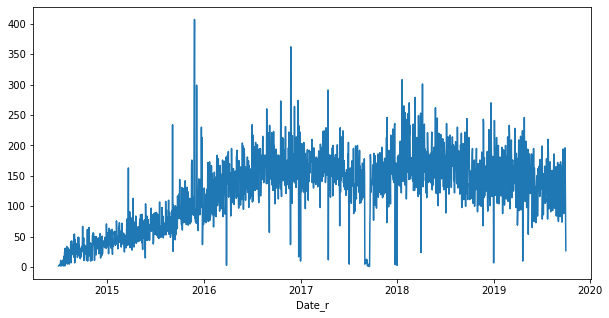

In [ ]:
ts=pets.groupby("Date_r")["Transaction ID"].count()
ts.plot(figsize=(10,5))

As you can observe, the number of transactions in Pets World rose from the lows of 2014s to reach a high in around 2017. From then on there is more or less a stable trend until late 2019 with number of transactions showing earliest signs of a decline.

###Customers

####How many distinct customers do Pets World have?

In [ ]:
pets.columns

Index(['Transaction ID', 'Date', 'Shop', 'System ID', 'Description', 'Brand',
       'Category', 'Qty', 'Retail', 'Sub Total', 'Discount', 'Tax Collected',
       'Tax', 'Total Collected', 'Cost', 'Customer', 'Employee', 'cat',
       'super_sub_cat', 'sub_cat', 'Date_r'],
      dtype='object')

In [ ]:
pets["Customer"].nunique()

8849

There are a total of 8848 customers for Pets World, excluding "Guest Customer" and "Unknown"

####Who are the top 20 customers for Pets World in terms of number of transactions?

Customer
Unknown                    4457
Denise  Van Hill           2255
Guest  Customer            1608
Christine  Verona          1179
Aaron  Amberg              1112
Karen  Piero                965
susan & sammy  Rojas        883
Christine  Fuller           846
Nancy  Barboza              838
Mark  Edgerton              816
ray miranda                 776
Jason  Dunn                 735
bob  richardson             731
Ron Pratt                   717
Douglas & Barbara  Feil     713
elizabeth  sell             651
TARA  POMEROY               645
Lorie  Armendariz           621
Christina  Jordan           569
dorrie  burke               558
Name: Transaction ID, dtype: int64


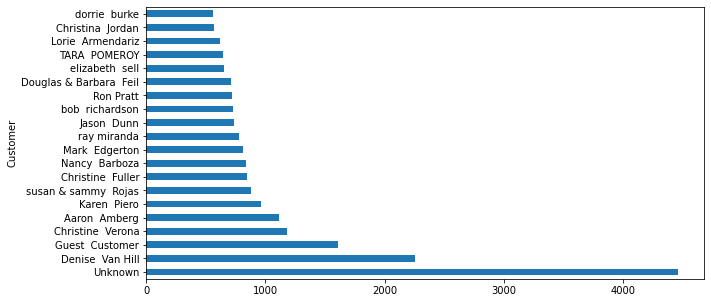

In [ ]:
top_cust=pets.groupby("Customer")["Transaction ID"].count().sort_values(ascending=False).head(20)
top_cust.plot.barh(figsize=(10,5))
print(top_cust)

###Employees

####How many employees were associated with Sales as per the dataset?

In [ ]:
pets["Employee"].nunique()

22




There were a total of 20 employees excluding "online crew" and "None"

####Employees ranked based on the number of transactions they attended to

Employee
None                   106348
Online Crew             34735
Janessa A Casasola      27741
Marisa F Maxey          16460
Ashley Pentz            13457
Felix Maya              10263
Melissa Twaite          10007
Courtney Hose            4820
Teddy Mealey             4639
Emilio Escarcega         4111
Josh Moshe               1517
Alejo Tello Paliero      1057
Jillian R Itow           1035
Giovanni Cortez           662
Luswyg De la Paz          373
Sean R Grady              244
Sarah M Sher               66
Bere Giannini              27
Jaime E Sundquist          26
Jamie Rahtz                 8
Amber Miletta               5
Noam Garini                 2
Name: Transaction ID, dtype: int64


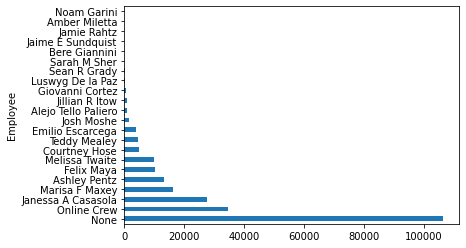

In [ ]:
emp_trans=pets.groupby("Employee")["Transaction ID"].count().sort_values(ascending=False)
emp_trans.plot.barh()
print(emp_trans)

###Orders

As you can see, most of the transactions were facilitated by online crew which signifies the online presence of the firm

In [ ]:
pets.columns

Index(['Transaction ID', 'Date', 'Shop', 'System ID', 'Description', 'Brand',
       'Category', 'Qty', 'Retail', 'Sub Total', 'Discount', 'Tax Collected',
       'Tax', 'Total Collected', 'Cost', 'Customer', 'Employee', 'cat',
       'super_sub_cat', 'sub_cat', 'Date_r'],
      dtype='object')

In [ ]:
pets.shape

(237603, 21)

####Returns on Orders

In [ ]:
returns=pets[pets["Qty"]<0]
returns.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6662 entries, 1 to 237455
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   Transaction ID   6662 non-null   int64              
 1   Date             6662 non-null   datetime64[ns, UTC]
 2   Shop             6662 non-null   object             
 3   System ID        6662 non-null   int64              
 4   Description      6662 non-null   object             
 5   Brand            6662 non-null   object             
 6   Category         6662 non-null   object             
 7   Qty              6662 non-null   int64              
 8   Retail           6662 non-null   float64            
 9   Sub Total        6662 non-null   float64            
 10  Discount         6662 non-null   float64            
 11  Tax Collected    6662 non-null   float64            
 12  Tax              6662 non-null   float64            
 13  Total Collected 

Out of the recorded transaction of 237603 transactions, 6662 are returned transactions

####Gross Sales

In [ ]:
sales=pets[pets["Qty"]>0]
sales.shape

(230941, 21)

In [ ]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 230941 entries, 0 to 237602
Data columns (total 21 columns):
 #   Column           Non-Null Count   Dtype              
---  ------           --------------   -----              
 0   Transaction ID   230941 non-null  int64              
 1   Date             230941 non-null  datetime64[ns, UTC]
 2   Shop             230941 non-null  object             
 3   System ID        230941 non-null  int64              
 4   Description      230941 non-null  object             
 5   Brand            230941 non-null  object             
 6   Category         230941 non-null  object             
 7   Qty              230941 non-null  int64              
 8   Retail           230941 non-null  float64            
 9   Sub Total        230941 non-null  float64            
 10  Discount         230941 non-null  float64            
 11  Tax Collected    230941 non-null  float64            
 12  Tax              230941 non-null  float64            
 13 

In [ ]:
6662+230941

237603

In [ ]:
sales["Total Collected"].sum()

4931867.99

###Sales & Revenue

####Correcting Accounts

In [ ]:
returns.sort_values("Total Collected", ascending=True).head(1)

,Transaction ID,Date,Shop,System ID,Description,Brand,Category,Qty,Retail,Sub Total,Discount,Tax Collected,Tax,Total Collected,Cost,Customer,Employee,cat,super_sub_cat,sub_cat,Date_r
174260,754658,2018-07-27 03:25:11.830565+00:00,Pets World,210000010963,Northwest Naturals Raw Diet Grain-Free Beef Di...,Northwest Naturals,Dog--> Raw Frozen --> Meat,-4,101.99,-407.96,40.8,-28.454,0.0775,-395.61,-243.0,joaquin torres,Melissa Twaite,Dog,Meat,Raw Frozen,2018-07-27


In [ ]:
returns.sort_values("Total Collected", ascending=True).tail(1)

,Transaction ID,Date,Shop,System ID,Description,Brand,Category,Qty,Retail,Sub Total,Discount,Tax Collected,Tax,Total Collected,Cost,Customer,Employee,cat,super_sub_cat,sub_cat,Date_r
117881,543421,2017-07-24 07:00:00+00:00,Pets World,210000008860,Naked DOG Raw Turkey Grain-Free Freeze Dried D...,Naked,Dog--> Raw Dried Food --> Poultry,-1,269.99,269.99,54.0,16.74,0.0775,232.73,185.71,Alicia Morris,None,Dog,Poultry,Raw Dried Food,2017-07-24


As can be observed, for orders retured, accounting is not done in a systematic manner leading to missappropriation of profits. On closer analysis, it became clear that such records where entered by workers who did not state their names. However, an employee named Melissa Twaide, has been found to be passing inconclusive entries with description "OOPs Item". In conclusion, accounting needs to be reworked.

In [ ]:
#creating a new returns file

rework_ret=returns

In [ ]:
#Reversing positive values in sub total columns as negative values
rework_ret["Sub Total"]=rework_ret["Qty"]*rework_ret["Retail"]

In [ ]:
len(rework_ret["Sub Total"])

6662

In [ ]:
x=lambda a:a*-1

In [ ]:
rework_ret.reset_index(inplace=True)

In [ ]:
pets["Category"][0]

'Dog --> Toys'

In [ ]:
pets["Tax Collected"][0]

0.48

In [ ]:
rework_ret["Retail"][0]

5.99

In [ ]:
for i in range(6662):
  if rework_ret["Tax Collected"][i] > 0:
   rework_ret["Tax Collected"][i]=rework_ret["Tax Collected"][i]*-1

In [ ]:
rework_ret.head(1)

,index,Transaction ID,Date,Shop,System ID,Description,Brand,Category,Qty,Retail,Sub Total,Discount,Tax Collected,Tax,Total Collected,Cost,Customer,Employee,cat,super_sub_cat,sub_cat,Date_r
0,1,14676,2014-07-01 07:00:00+00:00,Pets World,210000002077,Kong Squeezz Jels Hippo MD ** ARCHIVED **,Not Defined,Dog --> Toys,-1,5.99,-5.99,0.0,-0.48,0.08,6.47,3.02,Thomas John,None,Dog,None,Toys,2014-07-01


In [ ]:
rework_ret["Total Collected"]=rework_ret["Sub Total"]+rework_ret["Discount"]+rework_ret["Tax Collected"]

In [ ]:
s=sales["Total Collected"].sum()

In [ ]:
r=rework_ret["Total Collected"].sum()

####Total Gross Revenue Generated over the 5 year period

In [ ]:
tot_gross=s-r
print(tot_gross)

5092597.541


In [ ]:
sales.head(2)

,Transaction ID,Date,Shop,System ID,Description,Brand,Category,Qty,Retail,Sub Total,Discount,Tax Collected,Tax,Total Collected,Cost,Customer,Employee,cat,super_sub_cat,sub_cat,Date_r
0,14670,2014-07-01 07:00:00+00:00,Pets World,210000002077,Kong Squeezz Jels Hippo MD ** ARCHIVED **,Not Defined,Dog --> Toys,1,5.99,5.99,0.0,0.48,0.08,6.47,3.02,Thomas John,None,Dog,None,Toys,2014-07-01
3,14850,2014-07-02 07:00:00+00:00,Pets World,210000002043,Blue Buffalo Health Bars Baked with Banana & Y...,Blue Buffalo,Dog--> Treats --> Biscuit,1,6.99,6.99,0.0,0.56,0.08,7.55,3.58,Jasmin Parson,None,Dog,Biscuit,Treats,2014-07-02


####Gross Profit over the 5 years

In [ ]:
#Total of cost on items sold
c=sales["Cost"].sum()

In [ ]:
gross_profit=tot_gross-c
print(gross_profit)

2079360.6109999996


So, according to my estimates the gross profit over the 5 year is 2079360.6109999996

####Profit Margin of the company

In [ ]:
profit_mar=(gross_profit/tot_gross)*100
profit_mar

40.83104141372399

Profit Margin of the company is 40.8%

####Average Transaction Value

In [ ]:
sales.columns

Index(['Transaction ID', 'Date', 'Shop', 'System ID', 'Description', 'Brand',
       'Category', 'Qty', 'Retail', 'Sub Total', 'Discount', 'Tax Collected',
       'Tax', 'Total Collected', 'Cost', 'Customer', 'Employee', 'cat',
       'super_sub_cat', 'sub_cat', 'Date_r'],
      dtype='object')

In [ ]:
atv=sales["Total Collected"].mean()
print(atv)

21.355532322111326


####Average Tax Collected

In [ ]:
atc=sales["Tax Collected"].mean()
atc

1.5516913324183097

####Average Discount Provided

In [ ]:
avg_disc=sales["Discount"].mean()
avg_disc

-1.5723696528550786

In [ ]:
sales.Discount.describe()

count    230941.000000
mean         -1.572370
std           4.325213
min        -155.960000
25%          -1.400000
50%           0.000000
75%           0.000000
max           0.730000
Name: Discount, dtype: float64

In [ ]:
sales[sales["Discount"]<0]

,Transaction ID,Date,Shop,System ID,Description,Brand,Category,Qty,Retail,Sub Total,Discount,Tax Collected,Tax,Total Collected,Cost,Customer,Employee,cat,super_sub_cat,sub_cat,Date_r
6,15162,2014-07-03 07:00:00+00:00,Pets World,210000008692,Barkworthies Elk Antler Dog Chews 5-7 Inch MED...,Barkworthies,Dog--> Treats --> Bones & Bullies,1,7.99,7.99,-1.20,0.54,0.0800,7.33,4.82,Jasmin Parson,None,Dog,Bones & Bullies,Treats,2014-07-03
14,15750,2014-07-07 07:00:00+00:00,Pets World,210000002229,"Greenies Petite Dental Dog Treats 12z, 20 Count",Greenies,Dog--> Treats --> Dental,1,14.99,14.99,-5.00,0.80,0.0800,10.79,9.55,melinda brabo,None,Dog,Dental,Treats,2014-07-07
19,16128,2014-07-09 07:00:00+00:00,Pets World,210000000684,Taste of the Wild Pacific Stream Dry Dog Food ...,Taste of the Wild,Dog--> Dry Food --> Fish,1,43.99,43.99,-10.00,2.72,0.0800,36.71,35.36,Christina Dominguez,None,Dog,Fish,Dry Food,2014-07-09
24,16054,2014-07-09 07:00:00+00:00,Pets World,210000001186,"Rogue River Beef Pork Femur, ** ARCHIVED **",Not Defined,Dog--> Treats --> Bones & Bullies,1,2.70,2.70,-0.41,0.18,0.0800,2.47,1.35,Melissa Twaite,None,Dog,Bones & Bullies,Treats,2014-07-09
27,16054,2014-07-09 07:00:00+00:00,Pets World,2,Promo code: None,Not Defined,Not Defined,1,1.99,1.99,-0.30,0.14,0.0800,1.83,1.06,Melissa Twaite,None,Not Defined,None,None,2014-07-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237574,925183,2019-09-30 23:51:33.854332+00:00,Pets World,210000009186,Weruva Cats in the Kitchen 'Funk In The Trunk'...,Weruva,Cat--> Wet Food --> Poultry,7,1.98,13.86,-1.40,0.97,0.0775,13.43,8.68,Denise Panis,Teddy Mealey,Cat,Poultry,Wet Food,2019-09-30
237575,925183,2019-09-30 23:51:33.854332+00:00,Pets World,210000009117,Weruva Cats in the Kitchen 'Lamb Burgini' Lamb...,Weruva,Cat--> Wet Food --> Meat,3,2.00,6.00,-0.60,0.42,0.0775,5.82,3.72,Denise Panis,Teddy Mealey,Cat,Meat,Wet Food,2019-09-30
237577,925196,2019-10-01 00:15:00.652084+00:00,Pets World,210000007992,Northwest Naturals Raw Diet Grain-Free Chicken...,Northwest Naturals,Dog--> Raw Frozen --> Poultry,1,28.99,28.99,-2.90,2.02,0.0775,28.11,17.15,robyn royster,Teddy Mealey,Dog,Poultry,Raw Frozen,2019-10-01
237579,925196,2019-10-01 00:15:00.652084+00:00,Pets World,210000022656,Northwest Naturals Raw Diet Grain-Free Beef Nu...,Northwest Naturals,Dog--> Raw Frozen --> Meat,1,28.99,28.99,-2.90,2.02,0.0775,28.11,17.15,robyn royster,Teddy Mealey,Dog,Meat,Raw Frozen,2019-10-01


####Year wise Distribution of Revenue & Profit

#####Creating Required Data

In [ ]:
sales.columns

Index(['Transaction ID', 'Date', 'Shop', 'System ID', 'Description', 'Brand',
       'Category', 'Qty', 'Retail', 'Sub Total', 'Discount', 'Tax Collected',
       'Tax', 'Total Collected', 'Cost', 'Customer', 'Employee', 'cat',
       'super_sub_cat', 'sub_cat', 'Date_r'],
      dtype='object')

In [ ]:
sales["Year"]=sales["Date"].dt.year

In [ ]:
sales["Year"]

0         2014
3         2014
4         2014
5         2014
6         2014
          ... 
237598    2019
237599    2019
237600    2019
237601    2019
237602    2019
Name: Year, Length: 230941, dtype: int64

In [ ]:
rework_ret["Year"]=rework_ret["Date"].dt.year

In [ ]:
r=sales.groupby("Year")["Total Collected"].sum().reset_index()
r

,Year,Total Collected
0,2014,91124.33
1,2015,497528.72
2,2016,1105246.01
3,2017,1150831.35
4,2018,1251797.73
5,2019,835339.85


In [ ]:
g1=rework_ret.groupby("Year")["Total Collected"].sum().reset_index()
g1

,Year,Total Collected
0,2014,-2829.030
1,2015,-17496.280
2,2016,-33321.920
3,2017,-37140.453
4,2018,-44582.568
5,2019,-25359.300


In [ ]:
yearwise=r.merge(right=g1, how="left", on="Year")
yearwise

,Year,Total Collected_x,Total Collected_y
0,2014,91124.33,-2829.030
1,2015,497528.72,-17496.280
2,2016,1105246.01,-33321.920
3,2017,1150831.35,-37140.453
4,2018,1251797.73,-44582.568
5,2019,835339.85,-25359.300


In [ ]:
yearwise.rename(columns={"Total Collected_x":"Sales"}, inplace=True)

In [ ]:
yearwise.rename(columns={"Total Collected_y":"Returns"}, inplace=True)

In [ ]:
yearwise["Gross Revenue"]=yearwise["Sales"]-yearwise["Returns"]

#####Year with Highest Gross Revenue

In [ ]:
yearwise

,Year,Sales,Returns,Gross Revenue
0,2014,91124.33,-2829.030,93953.360
1,2015,497528.72,-17496.280,515025.000
2,2016,1105246.01,-33321.920,1138567.930
3,2017,1150831.35,-37140.453,1187971.803
4,2018,1251797.73,-44582.568,1296380.298
5,2019,835339.85,-25359.300,860699.150


As can be observed, 2018 was the year with most Revenue Generated


#####Year with Highest Total Cost

In [ ]:
s1=sales.groupby("Year")["Cost"].sum().reset_index()
s1

,Year,Cost
0,2014,65171.45
1,2015,329111.69
2,2016,645700.92
3,2017,703524.71
4,2018,761326.86
5,2019,508401.30


In [ ]:
yearwise=yearwise.merge(right=s1, how="left", on="Year")
yearwise

,Year,Sales,Returns,Gross Revenue,Cost
0,2014,91124.33,-2829.030,93953.360,65171.45
1,2015,497528.72,-17496.280,515025.000,329111.69
2,2016,1105246.01,-33321.920,1138567.930,645700.92
3,2017,1150831.35,-37140.453,1187971.803,703524.71
4,2018,1251797.73,-44582.568,1296380.298,761326.86
5,2019,835339.85,-25359.300,860699.150,508401.30


#####Year with Highest Gross Profit

In [ ]:
yearwise["Gross Profit"]=yearwise["Gross Revenue"]-yearwise["Cost"]
yearwise

,Year,Sales,Returns,Gross Revenue,Cost,Gross Profit
0,2014,91124.33,-2829.030,93953.360,65171.45,28781.910
1,2015,497528.72,-17496.280,515025.000,329111.69,185913.310
2,2016,1105246.01,-33321.920,1138567.930,645700.92,492867.010
3,2017,1150831.35,-37140.453,1187971.803,703524.71,484447.093
4,2018,1251797.73,-44582.568,1296380.298,761326.86,535053.438
5,2019,835339.85,-25359.300,860699.150,508401.30,352297.850


#####Plotting relevant observations

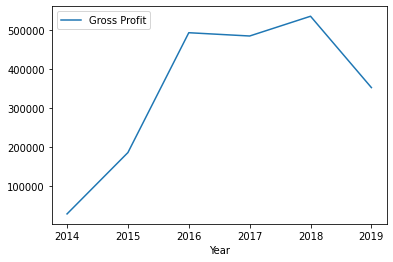

In [ ]:
yearwise.plot(x="Year", y="Gross Profit")

As you can see, the dates are from 2014 July till October 2019. So, the plot is not showing the exact growth of these two years. Apart from that, we can observe that there is an increasing rate of growth followed by a more or less stable phase.

Considering the growth rate in last quarter of 2019 is same as the rest of the year, we can safely predict that the sale would be around 1147598.66, which is below the ranges from 2018

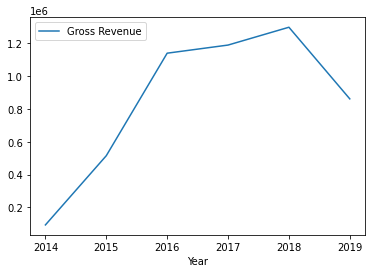

In [ ]:
yearwise.plot(x="Year", y="Gross Revenue")

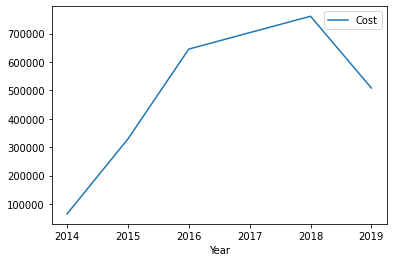

In [ ]:
yearwise.plot(x="Year", y="Cost")

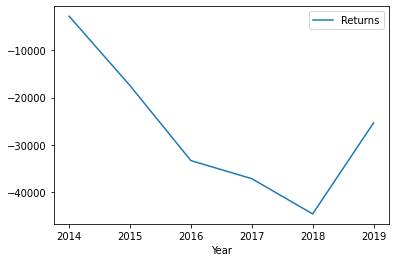

In [ ]:
yearwise.plot(x="Year", y="Returns")

As can be observed, the aggregate value of goods returned saw a steady increase from 2014 to 2018. But from 2018 till 2019 October, we could see a steady decrease in the aggregate value of goods returned. 

This shows that there is a slight improvement in efficient from 2018. But considering that the growth rate in sales was lesser compared to 2018, there is a significant impact of that factor too.

####Total Tax Collected

In [ ]:
pets.columns

Index(['Transaction ID', 'Date', 'Shop', 'System ID', 'Description', 'Brand',
       'Category', 'Qty', 'Retail', 'Sub Total', 'Discount', 'Tax Collected',
       'Tax', 'Total Collected', 'Cost', 'Customer', 'Employee', 'cat',
       'super_sub_cat', 'sub_cat', 'Date_r'],
      dtype='object')

#####Yearwise Distribution of Tax Collection

Year
2014     6710.720
2015    36568.060
2016    80003.700
2017    82865.208
2018    91285.122
2019    60916.338
Name: Tax Collected, dtype: float64


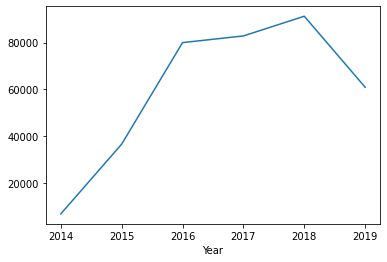

In [ ]:
t=sales.groupby("Year")["Tax Collected"].sum()
print(t)
t.plot()

In [ ]:
sales["Month"]=sales["Date"].dt.month

In [ ]:
sales["Month"].head()

0    7
3    7
4    7
5    7
6    7
Name: Month, dtype: int64

####Checking if time of the year has any significant impact on revenue generation

In [ ]:
sales.columns

Index(['Transaction ID', 'Date', 'Shop', 'System ID', 'Description', 'Brand',
       'Category', 'Qty', 'Retail', 'Sub Total', 'Discount', 'Tax Collected',
       'Tax', 'Total Collected', 'Cost', 'Customer', 'Employee', 'cat',
       'super_sub_cat', 'sub_cat', 'Date_r', 'Year', 'Month'],
      dtype='object')

#####The month with most sales over the 5 years

Month
1     415790.21
2     388579.89
3     434244.35
4     425227.32
5     441290.71
6     421280.17
7     419001.43
8     449891.76
9     389548.05
10    379367.05
11    377204.03
12    390443.02
Name: Total Collected, dtype: float64


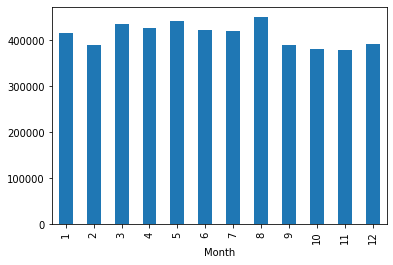

In [ ]:
mo=sales.groupby("Month")["Total Collected"].sum()
mo.plot.bar()
print(mo)

As can be observed, the month of August has the highest number of sales, followed by May and March

#####Month based plot of sales over the years

Year  Month
2014  7         3049.91
      8        12077.66
      9        16492.31
      10       17922.50
      11       19083.76
                 ...   
2019  6        91040.03
      7        88015.71
      8        90254.83
      9        87311.57
      10         695.80
Name: Total Collected, Length: 64, dtype: float64


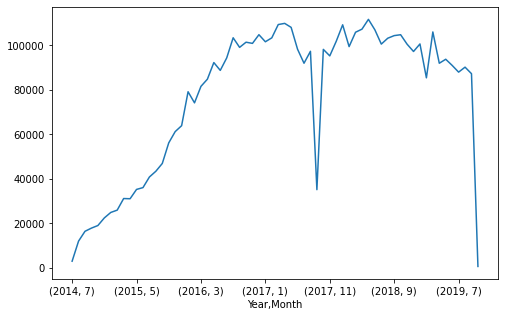

In [ ]:
mon=sales.groupby(["Year","Month"])["Total Collected"].sum()
mon.plot(figsize=(8,5))
print(mon)

#####Investigating the Drop in 2017

In [ ]:
sale2017=sales[sales["Year"]==2017]

In [ ]:
sale2017.shape

(52261, 23)

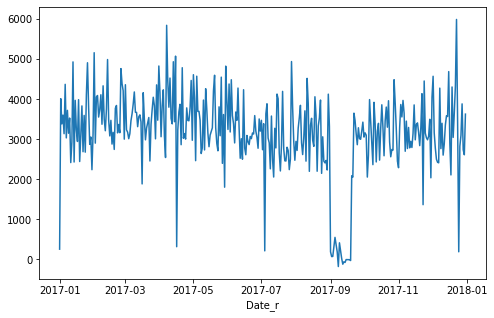

In [ ]:
s17=sale2017.groupby("Date_r")["Total Collected"].sum()
s17.plot(figsize=(8,5))

As can be observed, the continuous drop occured in September 2017. 

In [ ]:
pets.columns

Index(['Transaction ID', 'Date', 'Shop', 'System ID', 'Description', 'Brand',
       'Category', 'Qty', 'Retail', 'Sub Total', 'Discount', 'Tax Collected',
       'Tax', 'Total Collected', 'Cost', 'Customer', 'Employee', 'cat',
       'super_sub_cat', 'sub_cat', 'Date_r'],
      dtype='object')

In [ ]:
sales.columns

Index(['Transaction ID', 'Date', 'Shop', 'System ID', 'Description', 'Brand',
       'Category', 'Qty', 'Retail', 'Sub Total', 'Discount', 'Tax Collected',
       'Tax', 'Total Collected', 'Cost', 'Customer', 'Employee', 'cat',
       'super_sub_cat', 'sub_cat', 'Date_r', 'Year', 'Month'],
      dtype='object')

##Predictive Analytics

###Clustering Products based on Revenue generated and Number of units sold

####Preparing the data

In [ ]:
#Creating a list of active products

active=sales[~sales["Description"].str.contains("ARCHIVED")]

In [ ]:
active.columns

Index(['Transaction ID', 'Date', 'Shop', 'System ID', 'Description', 'Brand',
       'Category', 'Qty', 'Retail', 'Sub Total', 'Discount', 'Tax Collected',
       'Tax', 'Total Collected', 'Cost', 'Customer', 'Employee', 'cat',
       'super_sub_cat', 'sub_cat', 'Date_r', 'Year', 'Month'],
      dtype='object')

In [ ]:
active.shape

(207850, 23)

In [ ]:
active["Profit"]=active["Total Collected"]-active["Cost"]
active.head()

,Transaction ID,Date,Shop,System ID,Description,Brand,Category,Qty,Retail,Sub Total,Discount,Tax Collected,Tax,Total Collected,Cost,Customer,Employee,cat,super_sub_cat,sub_cat,Date_r,Year,Month,Profit
4,14790,2014-07-02 07:00:00+00:00,Pets World,210000001779,Nature's Variety Instinct Raw Signature Grain-...,Nature's Variety,Dog--> Raw Frozen --> Poultry,1,14.99,14.99,0.0,1.20,0.080,16.19,11.75,Tammi Wilson,None,Dog,Poultry,Raw Frozen,2014-07-02,2014,7,4.44
5,15100,2014-07-03 07:00:00+00:00,Pets World,210000001006,Cloud Star Dynamo Dog Hip & Joint Soft Chews C...,Cloud Star,Dog--> Treats --> Biscuit,1,6.14,6.14,0.0,0.49,0.080,6.63,3.07,Unknown,None,Dog,Biscuit,Treats,2014-07-03,2014,7,3.56
7,15100,2014-07-03 07:00:00+00:00,Pets World,210000008690,Blue Buffalo Wilderness Turkey & Chicken Grill...,Blue Buffalo,Dog--> Wet Food --> Poultry,1,2.59,2.59,0.0,0.21,0.080,2.80,1.87,Unknown,None,Dog,Poultry,Wet Food,2014-07-03,2014,7,0.93
8,15278,2014-07-05 07:00:00+00:00,Pets World,210000001678,Taste of the Wild High Prairie Grain-Free Cann...,Taste of the Wild,Dog--> Wet Food --> Exotic,1,1.99,1.99,0.0,0.15,0.075,2.14,1.56,Unknown,None,Dog,Exotic,Wet Food,2014-07-05,2014,7,0.58
9,15254,2014-07-05 07:00:00+00:00,Pets World,210000001678,Taste of the Wild High Prairie Grain-Free Cann...,Taste of the Wild,Dog--> Wet Food --> Exotic,1,1.99,1.99,0.0,0.16,0.080,2.15,1.56,Unknown,None,Dog,Exotic,Wet Food,2014-07-05,2014,7,0.59


In [ ]:
clus=active.groupby("Description").agg({"Qty":np.sum,"Profit":np.sum}).reset_index()
clus

,Description,Qty,Profit
0,8 in 1 Excel Roundworm De-Wormer Liquid for Ca...,4,17.20
1,ACANA Cat Regionals Appalachian Ranch Grain-Fr...,48,397.63
2,ACANA Cat Regionals Grasslands Grain-Free Dry ...,39,761.05
3,ACANA Cat Regionals Grasslands Grain-Free Dry ...,40,360.20
4,ACANA Cat Regionals Meadowland Grain-Free Dry ...,23,386.26
...,...,...,...
3225,coastal soy leash chocolate wide,10,87.53
3226,coastal soy leash olive wide,2,13.70
3227,coastal soy leash rose wide,4,33.87
3228,use oops item - Free Pound Naked - Dog Dry Chi...,1,-3.01


In [ ]:
X=clus.iloc[:,[1,2]].values
X

array([[  4.  ,  17.2 ],
       [ 48.  , 397.63],
       [ 39.  , 761.05],
       ...,
       [  4.  ,  33.87],
       [  1.  ,  -3.01],
       [  1.  ,  -3.22]])

####Using Elbow method to find the optimal number of clusters

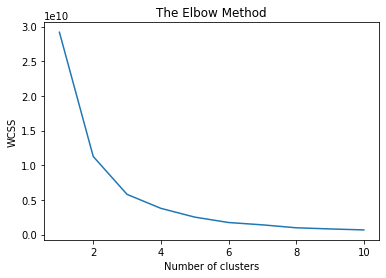

In [ ]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Based on the graph, i am going for number of clusters = 4

####Training K Means model on Data

In [ ]:
kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(X)

In [ ]:
y_kmeans.shape

(3230,)

####Visualizing Clusters

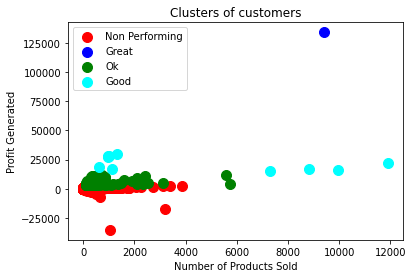

In [ ]:
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], s = 100, c = 'red', label = 'Non Performing')
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], s = 100, c = 'blue', label = 'Great')
plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], s = 100, c = 'green', label = 'Ok')
plt.scatter(X[y_kmeans == 3, 0], X[y_kmeans == 3, 1], s = 100, c = 'cyan', label = 'Good')
#plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 300, c = 'yellow', label = 'Centroids')
plt.title('Clusters of customers')
plt.xlabel('Number of Products Sold')
plt.ylabel('Profit Generated')
plt.legend()
plt.show()

In [ ]:
cluster=pd.DataFrame(y_kmeans)
cluster[0].value_counts()

0    3113
2     106
3      10
1       1
Name: 0, dtype: int64

In [ ]:
f_cluster=pd.concat([clus, cluster], axis=1)
f_cluster.columns

Index(['Description', 'Qty', 'Profit', 0], dtype='object')

In [ ]:
f_cluster=f_cluster.rename(columns={0:"Cluster"})
f_cluster

,Description,Qty,Profit,Cluster
0,8 in 1 Excel Roundworm De-Wormer Liquid for Ca...,4,17.20,0
1,ACANA Cat Regionals Appalachian Ranch Grain-Fr...,48,397.63,0
2,ACANA Cat Regionals Grasslands Grain-Free Dry ...,39,761.05,0
3,ACANA Cat Regionals Grasslands Grain-Free Dry ...,40,360.20,0
4,ACANA Cat Regionals Meadowland Grain-Free Dry ...,23,386.26,0
...,...,...,...,...
3225,coastal soy leash chocolate wide,10,87.53,0
3226,coastal soy leash olive wide,2,13.70,0
3227,coastal soy leash rose wide,4,33.87,0
3228,use oops item - Free Pound Naked - Dog Dry Chi...,1,-3.01,0


In [ ]:
for i in range(3230):
  if(f_cluster["Cluster"][i]==0):
    f_cluster["Cluster"][i]="Non Performing"
  elif(f_cluster["Cluster"][i]==1):
    f_cluster["Cluster"][i]="Great"
  elif(f_cluster["Cluster"][i]==2):
    f_cluster["Cluster"][i]="OK"
  elif(f_cluster["Cluster"][i]==3):
    f_cluster["Cluster"][i]="Good"

In [ ]:
temp=f_cluster.groupby("Cluster")["Description"].count()
temp

Cluster
Good                10
Great                1
Non Performing    3113
OK                 106
Name: Description, dtype: int64

As can be observed, there is only one exceptional product in the Great category which includes high number of products sold and high profit generation.

As can be observed, most of the products are in the Non Performing category. The inventory movement of those products must be carefully analysed and thus reduce the carrying cost of these products.



In [ ]:
#creating a new database for all future uses

products=f_cluster
products.columns

Index(['Description', 'Qty', 'Profit', 'Cluster'], dtype='object')

In [ ]:
#profit generated by all active products
products["Profit"].sum()

1752519.4800000086

####Quantitity Sold and Profit Generated in each product Cluster

In [ ]:
temp=products.groupby("Cluster").agg({"Qty":np.sum, "Profit":np.sum}).reset_index()
temp

,Cluster,Qty,Profit
0,Good,43869,218675.18
1,Great,9398,134090.75
2,Non Performing,267724,828637.35
3,OK,67010,571116.20


#####Cluster with HIghest Profit/ Unit sold

In [ ]:
temp["Profit / Unit"]=temp["Profit"]/temp["Qty"]
temp=temp.sort_values("Profit / Unit",ascending=False)
temp

,Cluster,Qty,Profit,Profit / Unit
1,Great,9398,134090.75,14.268009
3,OK,67010,571116.20,8.522850
0,Good,43869,218675.18,4.984731
2,Non Performing,267724,828637.35,3.095118


As can be observed, Profit / Unit is highest for the category of Great followed by OK category. 

###Clustering Brands based on Profit Generation

In [ ]:
sales.Brand.nunique()

238

In [ ]:
active.columns

Index(['Transaction ID', 'Date', 'Shop', 'System ID', 'Description', 'Brand',
       'Category', 'Qty', 'Retail', 'Sub Total', 'Discount', 'Tax Collected',
       'Tax', 'Total Collected', 'Cost', 'Customer', 'Employee', 'cat',
       'super_sub_cat', 'sub_cat', 'Date_r', 'Year', 'Month', 'Profit'],
      dtype='object')

In [ ]:
clus=active.groupby("Brand").agg({"Qty":np.sum,"Profit":np.sum}).reset_index()
clus

,Brand,Qty,Profit
0,8 in 1,4,17.20
1,Acana,3054,52292.71
2,Advantage,90,1034.49
3,Advantix,85,1259.17
4,Against The Grain,1161,1153.19
...,...,...,...
207,ZippyPaws,4,14.54
208,Ziwi Peak,751,6547.37
209,Zuke's,2628,11599.65
210,Zymox,24,195.60


In [ ]:
X=clus.iloc[:,[1,2]].values

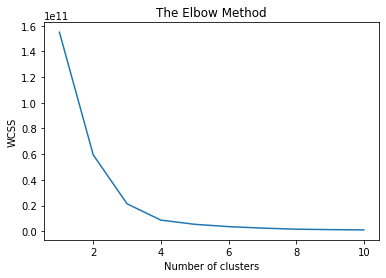

In [ ]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


In [ ]:
kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(X)

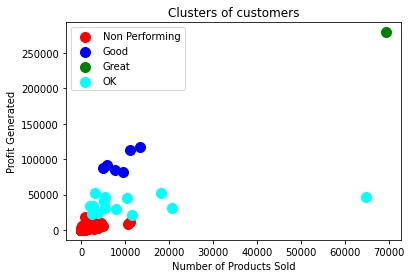

In [ ]:
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], s = 100, c = 'red', label = 'Non Performing')
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], s = 100, c = 'blue', label = 'Good')
plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], s = 100, c = 'green', label = 'Great')
plt.scatter(X[y_kmeans == 3, 0], X[y_kmeans == 3, 1], s = 100, c = 'cyan', label = 'OK')
#plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 300, c = 'yellow', label = 'Centroids')
plt.title('Clusters of customers')
plt.xlabel('Number of Products Sold')
plt.ylabel('Profit Generated')
plt.legend()
plt.show()


In [ ]:
cluster=pd.DataFrame(y_kmeans)
f_cluster=pd.concat([clus, cluster], axis=1)
f_cluster=f_cluster.rename(columns={0:"Cluster"})

In [ ]:
sales.Brand.nunique()

238

###Product Association Analysis

In [ ]:
sales.columns

Index(['Transaction ID', 'Date', 'Shop', 'System ID', 'Description', 'Brand',
       'Category', 'Qty', 'Retail', 'Sub Total', 'Discount', 'Tax Collected',
       'Tax', 'Total Collected', 'Cost', 'Customer', 'Employee', 'cat',
       'super_sub_cat', 'sub_cat', 'Date_r', 'Year', 'Month'],
      dtype='object')

In [ ]:
sales.shape

(230941, 23)

In [ ]:
#Filtering for active products

sales=sales[~sales["Description"].str.contains("ARCHIVED")]
sales.shape

(207850, 23)

In [ ]:
top500=sales.groupby("Description")["Transaction ID"].count().sort_values(ascending=False).reset_index().head(500)
top500.head()

,Description,Transaction ID
0,Promo code: None,9093
1,Promo code: iruffyou,3176
2,Naked DOG Chicken Grain-Free Dry Dog Food By t...,1923
3,Naked DOG Beef Grain-Free Potato-Free Dry Dog ...,1561
4,Naked DOG Lamb and Brown Rice Dry Dog Food By ...,1521


In [ ]:
productID=top500["Description"].reset_index()
productID.head()

,index,Description
0,0,Promo code: None
1,1,Promo code: iruffyou
2,2,Naked DOG Chicken Grain-Free Dry Dog Food By t...
3,3,Naked DOG Beef Grain-Free Potato-Free Dry Dog ...
4,4,Naked DOG Lamb and Brown Rice Dry Dog Food By ...


In [ ]:
#creating an iteration process

df=sales[0:0]
for i in range (0,500):
    pID=productID.iloc[i]['Description']
    stDF=sales[sales['Description']==pID]
    df=df.append(stDF, ignore_index=False)
    
df.columns

Index(['Transaction ID', 'Date', 'Shop', 'System ID', 'Description', 'Brand',
       'Category', 'Qty', 'Retail', 'Sub Total', 'Discount', 'Tax Collected',
       'Tax', 'Total Collected', 'Cost', 'Customer', 'Employee', 'cat',
       'super_sub_cat', 'sub_cat', 'Date_r', 'Year', 'Month'],
      dtype='object')

In [ ]:
#Convert the data into a wide data where - row - transcation - column - products

basket=df.groupby(['Transaction ID','Description']).size().reset_index()
basket.head()

,Transaction ID,Description,0
0,15100,Blue Buffalo Wilderness Turkey & Chicken Grill...,1
1,15100,Cloud Star Dynamo Dog Hip & Joint Soft Chews C...,1
2,15220,Zuke's Mini Naturals Roasted Chicken Dog Treat...,1
3,15582,Weruva BFF Grain-Free Tuna & Turkey Tickles Re...,1
4,15582,Weruva Cats in the Kitchen 'Pumpkin Jack Splas...,1


In [ ]:
basket1=basket.pivot('Transaction ID','Description',0)
basket1.head()

Description,ACANA Dog Regionals Appalachian Ranch Grain-Free Dry Dog Food 4.5lbs,ACANA Dog Regionals Meadowland Grain-Free Dry Dog Food 25lbs,ACANA Dog Regionals Meadowland Grain-Free Dry Dog Food 4.5lbs,ACANA Dog Regionals Wild Atlantic Grain-Free Dry Dog Food 25lbs,ACANA Dog Regionals Wild Atlantic Grain-Free Dry Dog Food 4.5lbs,ACANA Dog Singles Duck & Pear Formula Dry Dog Food 25lbs,ACANA Dog Singles Duck & Pear Formula Dry Dog Food 4.5lbs,ACANA Dog Singles Lamb & Apple Formula Dry Dog Food 13lbs,ACANA Dog Singles Lamb & Apple Formula Dry Dog Food 25lbs,ACANA Dog Singles Lamb & Apple Formula Dry Dog Food 4.5lbs,ACANA Dog Singles Pork & Squash Formula Dry Dog Food 25lbs,Against The Grain 'Nothing Else' 100% Beef Canned Dog Food 11z,Answers Additional Raw Goat's Milk for Cats & Dogs 0.5 gallon (64z),Answers Additional Raw Goat's Milk for Cats & Dogs 1 pint (16z),Answers Additional Raw Goat's Milk for Cats & Dogs 1 quart (32z),Barkworthies Beef Tripe Twist Dog Treat SMALL,Barkworthies Curly Bully Sticks Dog Treats,Barkworthies Elk Antler Dog Chews SMALL,Barkworthies Elk Antler Split Dog Chews LARGE,Barkworthies Elk Antler Split Dog Chews X-LARGE,Barkworthies Elk Antler Splits Dog Chews 4-5 Inch SMALL,Barkworthies Odor-Free Double Cut Bully Sticks Dog Treat - 6 Inch,Barkworthies Odor-Free Standard Bully Sticks Dog Chew Treat 12 Inch,Barkworthies Odor-Free Standard Bully Sticks Dog Chew Treats 6 Inch,Barkworthies Odor-Free Thick Bully Sticks Dog Treats 12 Inch,Barkworthies Odor-Free Twisted Bully Sticks Dog Treats 6 Inch,Blue Buffalo Homestyle Recipe Chicken Dinner with Garden Vegetables & Brown Rice Canned Dog Food 12.5z (*),Blue Buffalo Homestyle Recipe Senior Chicken Dinner with Garden Vegetables Canned Dog Food 12.5z (*),Blue Buffalo Life Protection Formula Adult Chicken & Brown Rice Recipe Dry Dog Food 30lbs (*),Blue Buffalo Wilderness Turkey & Chicken Grill Grain-Free Canned Dog Food 12.5z (*),Buddy Biscuits Grain-Free Oven Baked with Homestyle Peanut Butter Dog Treats 14z,Buddy Biscuits Grain-Free Oven Baked with Rotisserie Chicken Dog Treats 14z,Buddy Biscuits Grain-Free Soft & Chewy with Peanut Butter Dog Treats 5z,Buddy Biscuits Grain-Free Soft & Chewy with Rotisserie Chicken Dog Treats 5z,Buddy Biscuits Grain-Free Soft & Chewy with Slow Roasted Beef Dog Treats 5z,Buddy Biscuits Oven Baked Bacon & Cheese Dog Treats 16z,Buddy Biscuits Oven Baked Teeny Treats with Roasted Chicken Dog Treats 8z,Buddy Wash Lavender & Mint 2 in 1 Shampoo & Conditioner 16z,Canidae All Life Stages Chicken & Rice Formula Canned Dog Food 13z,Canidae All Life Stages Lamb & Rice Formula Canned Dog Food 13z,...,Whimzees Toothbrush Chews Star All-natural Dog Treats- Small 24 count,Whimzees Toothbrush Chews Star All-natural Dog Treats- XS 48 count,Wild Calling Chicken Coop 96% Chicken Grain-Free Canned Dog Food 13z (*),Wild Calling Country Best 96% Pork Grain-Free Canned Dog Food 13z (*),Wild Calling Rabbit Burrow 96% Rabbit Grain-Free Canned Cat Food 5.5z (*),Wild Calling Western Plains 96% Beef Grain-Free Canned Dog Food 13z (*),Zignature Grain-Free Duck Limited Ingredient Formula Canned Dog Food 13z,Zignature Grain-Free Duck Limited Ingredient Formula Dry Dog Food 27lbs,Zignature Grain-Free Duck Limited Ingredient Formula Dry Dog Food 4lbs,Zignature Grain-Free Lamb Limited Ingredient Formula Canned Dog Food 13z,Zignature Grain-Free Lamb Limited Ingredient Formula Dry Dog Food 27lbs,Zignature Grain-Free Lamb Limited Ingredient Formula Dry Dog Food 4lbs,Zignature Grain-Free Pork Limited Ingredient Formula Dry Dog Food 27lbs,Zignature Grain-Free Pork Limited Ingredient Formula Dry Dog Food 4lbs,Zignature Grain-Free Salmon Limited Ingredient Formula Dry Dog Food 27lbs,Zignature Grain-Free Salmon Limited Ingredient Formula Dry Dog Food 4lbs,Zignature Grain-Free Trout & Salmon Limited Ingredient Formula Canned Dog Food 13z,Zignature Grain-Free Trout & Salmon Meal Limited Ingredient Formula Dry Dog Food 13.5lbs,Zignature Grain-Free Trout & Salmon Meal 

In [ ]:
#Replacing NaN values

basket2= basket1.fillna(0)
basket2.head()

Description,ACANA Dog Regionals Appalachian Ranch Grain-Free Dry Dog Food 4.5lbs,ACANA Dog Regionals Meadowland Grain-Free Dry Dog Food 25lbs,ACANA Dog Regionals Meadowland Grain-Free Dry Dog Food 4.5lbs,ACANA Dog Regionals Wild Atlantic Grain-Free Dry Dog Food 25lbs,ACANA Dog Regionals Wild Atlantic Grain-Free Dry Dog Food 4.5lbs,ACANA Dog Singles Duck & Pear Formula Dry Dog Food 25lbs,ACANA Dog Singles Duck & Pear Formula Dry Dog Food 4.5lbs,ACANA Dog Singles Lamb & Apple Formula Dry Dog Food 13lbs,ACANA Dog Singles Lamb & Apple Formula Dry Dog Food 25lbs,ACANA Dog Singles Lamb & Apple Formula Dry Dog Food 4.5lbs,ACANA Dog Singles Pork & Squash Formula Dry Dog Food 25lbs,Against The Grain 'Nothing Else' 100% Beef Canned Dog Food 11z,Answers Additional Raw Goat's Milk for Cats & Dogs 0.5 gallon (64z),Answers Additional Raw Goat's Milk for Cats & Dogs 1 pint (16z),Answers Additional Raw Goat's Milk for Cats & Dogs 1 quart (32z),Barkworthies Beef Tripe Twist Dog Treat SMALL,Barkworthies Curly Bully Sticks Dog Treats,Barkworthies Elk Antler Dog Chews SMALL,Barkworthies Elk Antler Split Dog Chews LARGE,Barkworthies Elk Antler Split Dog Chews X-LARGE,Barkworthies Elk Antler Splits Dog Chews 4-5 Inch SMALL,Barkworthies Odor-Free Double Cut Bully Sticks Dog Treat - 6 Inch,Barkworthies Odor-Free Standard Bully Sticks Dog Chew Treat 12 Inch,Barkworthies Odor-Free Standard Bully Sticks Dog Chew Treats 6 Inch,Barkworthies Odor-Free Thick Bully Sticks Dog Treats 12 Inch,Barkworthies Odor-Free Twisted Bully Sticks Dog Treats 6 Inch,Blue Buffalo Homestyle Recipe Chicken Dinner with Garden Vegetables & Brown Rice Canned Dog Food 12.5z (*),Blue Buffalo Homestyle Recipe Senior Chicken Dinner with Garden Vegetables Canned Dog Food 12.5z (*),Blue Buffalo Life Protection Formula Adult Chicken & Brown Rice Recipe Dry Dog Food 30lbs (*),Blue Buffalo Wilderness Turkey & Chicken Grill Grain-Free Canned Dog Food 12.5z (*),Buddy Biscuits Grain-Free Oven Baked with Homestyle Peanut Butter Dog Treats 14z,Buddy Biscuits Grain-Free Oven Baked with Rotisserie Chicken Dog Treats 14z,Buddy Biscuits Grain-Free Soft & Chewy with Peanut Butter Dog Treats 5z,Buddy Biscuits Grain-Free Soft & Chewy with Rotisserie Chicken Dog Treats 5z,Buddy Biscuits Grain-Free Soft & Chewy with Slow Roasted Beef Dog Treats 5z,Buddy Biscuits Oven Baked Bacon & Cheese Dog Treats 16z,Buddy Biscuits Oven Baked Teeny Treats with Roasted Chicken Dog Treats 8z,Buddy Wash Lavender & Mint 2 in 1 Shampoo & Conditioner 16z,Canidae All Life Stages Chicken & Rice Formula Canned Dog Food 13z,Canidae All Life Stages Lamb & Rice Formula Canned Dog Food 13z,...,Whimzees Toothbrush Chews Star All-natural Dog Treats- Small 24 count,Whimzees Toothbrush Chews Star All-natural Dog Treats- XS 48 count,Wild Calling Chicken Coop 96% Chicken Grain-Free Canned Dog Food 13z (*),Wild Calling Country Best 96% Pork Grain-Free Canned Dog Food 13z (*),Wild Calling Rabbit Burrow 96% Rabbit Grain-Free Canned Cat Food 5.5z (*),Wild Calling Western Plains 96% Beef Grain-Free Canned Dog Food 13z (*),Zignature Grain-Free Duck Limited Ingredient Formula Canned Dog Food 13z,Zignature Grain-Free Duck Limited Ingredient Formula Dry Dog Food 27lbs,Zignature Grain-Free Duck Limited Ingredient Formula Dry Dog Food 4lbs,Zignature Grain-Free Lamb Limited Ingredient Formula Canned Dog Food 13z,Zignature Grain-Free Lamb Limited Ingredient Formula Dry Dog Food 27lbs,Zignature Grain-Free Lamb Limited Ingredient Formula Dry Dog Food 4lbs,Zignature Grain-Free Pork Limited Ingredient Formula Dry Dog Food 27lbs,Zignature Grain-Free Pork Limited Ingredient Formula Dry Dog Food 4lbs,Zignature Grain-Free Salmon Limited Ingredient Formula Dry Dog Food 27lbs,Zignature Grain-Free Salmon Limited Ingredient Formula Dry Dog Food 4lbs,Zignature Grain-Free Trout & Salmon Limited Ingredient Formula Canned Dog Food 13z,Zignature Grain-Free Trout & Salmon Meal Limited Ingredient Formula Dry Dog Food 13.5lbs,Zignature Grain-Free Trout & Salmon Meal 

In [ ]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

basket_sets = basket2.applymap(encode_units)

In [ ]:
freq_items=apriori(basket_sets, min_support=0.003, use_colnames=True)
freq_items.sort_values(by='support', ascending=False).head()

,support,itemsets
110,0.113726,(Promo code: None)
112,0.040339,(Promo code: iruffyou)
63,0.024424,(Naked DOG Chicken Grain-Free Dry Dog Food By ...
61,0.019827,(Naked DOG Beef Grain-Free Potato-Free Dry Dog...
65,0.019318,(Naked DOG Lamb and Brown Rice Dry Dog Food By...


In [ ]:
rules = association_rules(freq_items, metric="lift", min_threshold=.1)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Naked DOG Chicken Grain-Free Dry Dog Food By ...,(Promo code: None),0.024424,0.113726,0.004090,0.167447,1.472368,0.001312,1.064525
1,(Promo code: None),(Naked DOG Chicken Grain-Free Dry Dog Food By ...,0.113726,0.024424,0.004090,0.035962,1.472368,0.001312,1.011968
2,(Promo code: None),(Naked DOG Lamb and Brown Rice Dry Dog Food 50...,0.113726,0.015546,0.003429,0.030154,1.939644,0.001661,1.015062
3,(Naked DOG Lamb and Brown Rice Dry Dog Food 50...,(Promo code: None),0.015546,0.113726,0.003429,0.220588,1.939644,0.001661,1.137106
4,(Naked DOG Lamb and Brown Rice Dry Dog Food By...,(Promo code: None),0.019318,0.113726,0.003772,0.195266,1.716987,0.001575,1.101326
5,(Promo code: None),(Naked DOG Lamb and Brown Rice Dry Dog Food By...,0.113726,0.019318,0.003772,0.033170,1.716987,0.001575,1.014326
6,(Weruva Funky Chunky Chicken Soup with Pumpkin...,"(Weruva Wok the Dog with Chicken, Beef & Pumpk...",0.006109,0.007290,0.003810,0.623701,85.550211,0.003766,2.638084
7,"(Weruva Wok the Dog with Chicken, Beef & Pumpk...",(Weruva Funky Chunky Chicken Soup with Pumpkin...,0.007290,0.006109,0.003810,0.522648,85.550211,0.003766,2.082092
8,(Weruva Grain-Free Mack and Jack with Mackerel...,(Weruva Grain-Free Mideast Feast with Grilled ...,0.006452,0.008218,0.004217,0.653543,79.529251,0.004164,2.862645
9,(Weruva Grain-Free Mideast Feast with Grilled ...,(Weruva Grain-Free Mack and Jack with Mackerel...,0.008218,0.006452,0.004217,0.513138,79.529251,0.004164,2.040716


The above table shows that (Naked DOG Chicken Grain-Free Dry Dog Food By ...	is most frequently brought with the promo code

#####Analysis on product combinations excluding promo codes

In [ ]:
sales=sales[~sales["Description"].str.contains("Promo code:")]

In [ ]:
top500=sales.groupby("Description")["Transaction ID"].count().sort_values(ascending=False).reset_index().head(500)
productID=top500["Description"].reset_index()
#creating an iteration process

df=sales[0:0]
for i in range (0,500):
    pID=productID.iloc[i]['Description']
    stDF=sales[sales['Description']==pID]
    df=df.append(stDF, ignore_index=False)

basket=df.groupby(['Transaction ID','Description']).size().reset_index()
basket1=basket.pivot('Transaction ID','Description',0)
basket2= basket1.fillna(0)
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

basket_sets = basket2.applymap(encode_units)
freq_items=apriori(basket_sets, min_support=0.003, use_colnames=True)
freq_items.sort_values(by='support', ascending=False).head()

,support,itemsets
69,0.025400,(Naked DOG Chicken Grain-Free Dry Dog Food By ...
67,0.020618,(Naked DOG Beef Grain-Free Potato-Free Dry Dog...
71,0.020090,(Naked DOG Lamb and Brown Rice Dry Dog Food By...
125,0.019152,(RedBarn Cow Hooves Dog Treat)
78,0.018426,(Naked DOG Salmon Grain-Free Potato-Free Dry D...


In [ ]:
rules = association_rules(freq_items, metric="lift", min_threshold=.1)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Naked DOG Lamb and Brown Rice Dry Dog Food By...,(Naked DOG Chicken Grain-Free Dry Dog Food By ...,0.020090,0.025400,0.003104,0.154504,6.082927,0.002594,1.152696
1,(Naked DOG Chicken Grain-Free Dry Dog Food By ...,(Naked DOG Lamb and Brown Rice Dry Dog Food By...,0.025400,0.020090,0.003104,0.122205,6.082927,0.002594,1.116331
2,(Weruva BFF Grain-Free Tuna & Salmon Soulmates...,(Weruva BFF Grain-Free Tuna & Tilapia Twosome ...,0.006076,0.005191,0.003091,0.508696,97.998341,0.003059,2.024833
3,(Weruva BFF Grain-Free Tuna & Tilapia Twosome ...,(Weruva BFF Grain-Free Tuna & Salmon Soulmates...,0.005191,0.006076,0.003091,0.595420,97.998341,0.003059,2.456681
4,(Weruva Funky Chunky Chicken Soup with Pumpkin...,"(Weruva Wok the Dog with Chicken, Beef & Pumpk...",0.006353,0.007582,0.003962,0.623701,82.265460,0.003914,2.637311
5,"(Weruva Wok the Dog with Chicken, Beef & Pumpk...",(Weruva Funky Chunky Chicken Soup with Pumpkin...,0.007582,0.006353,0.003962,0.522648,82.265460,0.003914,2.081581
6,(Weruva Grain-Free Mack and Jack with Mackerel...,(Weruva Grain-Free Mideast Feast with Grilled ...,0.006710,0.008546,0.004385,0.653543,76.475678,0.004328,2.861697
7,(Weruva Grain-Free Mideast Feast with Grilled ...,(Weruva Grain-Free Mack and Jack with Mackerel...,0.008546,0.006710,0.004385,0.513138,76.475678,0.004328,2.040187
8,(Weruva Grain-Free Mack and Jack with Mackerel...,(Weruva Grain-Free Polynesian BBQ with Grilled...,0.006710,0.006565,0.003976,0.592520,90.260896,0.003932,2.437996
9,(Weruva Grain-Free Polynesian BBQ with Grilled...,(Weruva Grain-Free Mack and Jack with Mackerel...,0.006565,0.006710,0.003976,0.605634,90.260896,0.003932,2.518700


The above listed are the most prominent product associations that can be used to make informed marketing decisions

###Sales Forecast using LSTM

In [ ]:
sales.columns

Index(['Transaction ID', 'Date', 'Shop', 'System ID', 'Description', 'Brand',
       'Category', 'Qty', 'Retail', 'Sub Total', 'Discount', 'Tax Collected',
       'Tax', 'Total Collected', 'Cost', 'Customer', 'Employee', 'cat',
       'super_sub_cat', 'sub_cat', 'Date_r', 'Year', 'Month'],
      dtype='object')

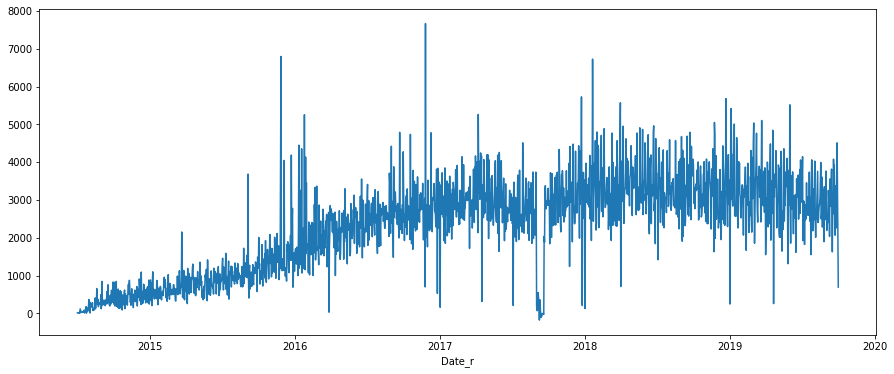

In [ ]:
grp=sales.groupby("Date_r")["Total Collected"].sum()
grp.plot(figsize=(15,6))

In [ ]:
grp=grp.reset_index()

In [ ]:
#Preparing Training data
start=pd.to_datetime("2014-07-01")
end=pd.to_datetime("2019-06-30")

mask = (grp['Date_r'] > start) & (grp['Date_r'] <= end)
training_data=grp.loc[mask]
training_data.shape


(1809, 2)

In [ ]:
training_data.head(1)

,Date_r,Total Collected
0,2014-07-02,16.19


In [ ]:
#Preparing Test data
start=pd.to_datetime("2019-07-01")
end=pd.to_datetime("2019-07-31")

mask = (grp['Date_r'] > start) & (grp['Date_r'] <= end)
test_data=grp.loc[mask]
test_data.shape

(30, 2)

In [ ]:
training_set=training_data.iloc[:,1:2].values
training_set

array([[  16.19],
       [   9.43],
       [   9.58],
       ...,
       [4060.06],
       [3326.77],
       [3179.  ]])

In [ ]:
#Feature scaling

from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [ ]:
#Creating data structure with 30 timesteps and one output

X_train = [] # list containing all the previous 30 net sales values
y_train = []
for i in range(30, 1809):
    X_train.append(training_set_scaled[i-30:i, 0])
    y_train.append(training_set_scaled[i, 0])

#We are converting the X_train and y_train into numpy arrays
X_train, y_train = np.array(X_train), np.array(y_train)

In [ ]:
#reshaping to create the 3D structure expected by the neural network

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [ ]:
#initializing RNN
regressor = Sequential() #regressor represents a sequence of layers

In [ ]:
#Adding first LSTM Model
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
#units represent the number of LSTM cells or units we want to have in this LSTM layer
#We chose a large number as the number of neurons to increase the dimensionality
#return sequence is supposed to be true if we are adding additional layers of LSTM

regressor.add(Dropout(0.2))
#Dropout rate is the rate of neurons you want to drop or ignore in the layers. The classic number is .20
#During each iteration of the training 20% of the neuron will be dropped out

In [ ]:
#Adding additional layers of LSTM

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

#so, in total we have 4 layers of LSTM

#Adding the output layer

regressor.add(Dense(units = 1))

In [ ]:
#compiling the RNN

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [ ]:
#Fitting RNN to the training set

regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)
#epoch is the number of times the data is forward propagated and readjusted for weights

Epoch 1/100
1779/1779 [==============================] - 6s 3ms/step - loss: 0.0186
Epoch 2/100
1779/1779 [==============================] - 4s 2ms/step - loss: 0.0097
Epoch 3/100
1779/1779 [==============================] - 4s 2ms/step - loss: 0.0095
Epoch 4/100
1779/1779 [==============================] - 4s 2ms/step - loss: 0.0105
Epoch 5/100
1779/1779 [==============================] - 4s 2ms/step - loss: 0.0097
Epoch 6/100
1779/1779 [==============================] - 4s 2ms/step - loss: 0.0093
Epoch 7/100
1779/1779 [==============================] - 4s 2ms/step - loss: 0.0094
Epoch 8/100
1779/1779 [==============================] - 4s 2ms/step - loss: 0.0094
Epoch 9/100
1779/1779 [==============================] - 4s 2ms/step - loss: 0.0090
Epoch 10/100
1779/1779 [==============================] - 4s 2ms/step - loss: 0.0094
Epoch 11/100
1779/1779 [==============================] - 4s 2ms/step - loss: 0.0090
Epoch 12/100
1779/1779 [==============================] - 4s 2ms/step - lo

In [ ]:
#Making predictions and visualizing results

testing_set=test_data.iloc[:,1:2].values

In [ ]:
#getting the real sales value for may 2018

dataset_total = pd.concat((training_data['Total Collected'], test_data['Total Collected']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test_data) - 30:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(30, 60):
    X_test.append(inputs[i-30:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_sales_values = regressor.predict(X_test)
predicted_sales_values = sc.inverse_transform(predicted_sales_values)

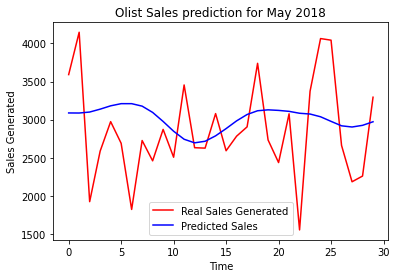

In [ ]:
#visualizing predictions

plt.plot(testing_set, color = 'red', label = 'Real Sales Generated')
plt.plot(predicted_sales_values, color = 'blue', label = 'Predicted Sales')
plt.title('Olist Sales prediction for May 2018')
plt.xlabel('Time')
plt.ylabel('Sales Generated')
plt.legend()
plt.show()

###Customer Segmentation - RFM Clustering

####Calculating Recency

In [ ]:
sales.columns

Index(['Transaction ID', 'Date', 'Shop', 'System ID', 'Description', 'Brand',
       'Category', 'Qty', 'Retail', 'Sub Total', 'Discount', 'Tax Collected',
       'Tax', 'Total Collected', 'Cost', 'Customer', 'Employee', 'cat',
       'super_sub_cat', 'sub_cat', 'Date_r', 'Year', 'Month'],
      dtype='object')

In [ ]:
customer=pd.DataFrame(sales["Customer"].unique())
customer.columns=["Customer"]

In [ ]:
#get the max purchase date for each customer and create a dataframe with it

tx_max_purchase = sales.groupby('Customer').Date_r.max().reset_index()
tx_max_purchase.columns = ['Customer','MaxPurchaseDate']

In [ ]:
#we take our observation point as the max invoice date in our dataset
tx_max_purchase['Recency'] = (tx_max_purchase['MaxPurchaseDate'].max() - tx_max_purchase['MaxPurchaseDate']).dt.days

In [ ]:
#merge this dataframe to our new user dataframe
customer= pd.merge(customer, tx_max_purchase[['Customer','Recency']], on='Customer')

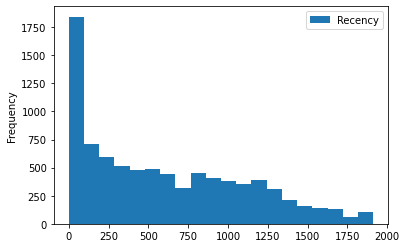

In [ ]:
#plotting histogram of recency

customer.plot.hist(by="Recency",bins=20)

In [ ]:
customer.Recency.describe()

count    8488.000000
mean      598.164114
std       504.740378
min         0.000000
25%       129.000000
50%       499.000000
75%       986.000000
max      1912.000000
Name: Recency, dtype: float64

As can be observed, Pets World enjoys a regular set of customers who are frequent, thus the frequency of recency is highest between zero and 50

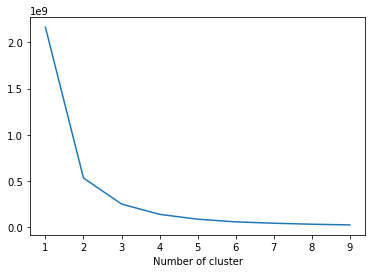

In [ ]:
#Applying K Means clustering on Recency
#Generating Elbow method

sse={}
tx_recency = customer[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_recency)
    tx_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

As the elbow method suggest, optimal clusters would be 3 for the present scenario

In [ ]:
#build 3 clusters for recency and add it to dataframe
kmeans = KMeans(n_clusters=3)
kmeans.fit(customer[['Recency']])
customer['RecencyCluster'] = kmeans.predict(customer[['Recency']])

In [ ]:
#function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

order_cluster('RecencyCluster', 'Recency',customer,False)

,Customer,Recency,RecencyCluster
0,Tammi Wilson,255,2
1,Unknown,82,2
2,Laura Ruiz,121,2
3,Robert Egbert,325,2
4,Melissa Twaite,192,2
...,...,...,...
8483,Andy Torres,426,1
8484,christine bushman,426,1
8485,eddie padilla,426,1
8486,Josh Mangram,426,1


In [ ]:
customer.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,3872.0,144.125258,128.175866,0.0,26.0,106.0,246.0,425.0
1,1983.0,1335.648512,233.304864,1021.0,1151.5,1274.0,1486.5,1912.0
2,2633.0,710.434106,175.175629,426.0,553.0,698.0,864.0,1020.0


As per the recency table above, cluster 1 covers all the most recent customers while cluster 0 the least recent ones

####Calculating Frequency

In [ ]:
customer.head()

,Customer,Recency,RecencyCluster
0,Tammi Wilson,255,0
1,Unknown,82,0
2,Laura Ruiz,121,0
3,elizabeth zapata,1912,1
4,melinda brabo,1912,1


In [ ]:
#get order counts for each user and create a dataframe with it
tx_frequency = sales.groupby('Customer').Date_r.count().reset_index()
tx_frequency.columns = ['Customer','Frequency']

In [ ]:
#add this data to our main dataframe
customer = pd.merge(customer, tx_frequency, on='Customer')

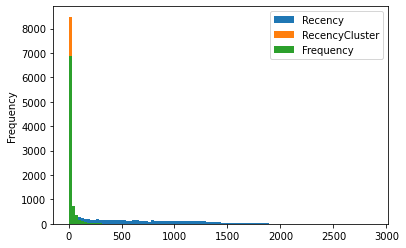

In [ ]:
#plotting frequency

customer.plot.hist(by="Frequency",bins=100)

In [ ]:
#k-means clustering for frequency

kmeans = KMeans(n_clusters=3)
kmeans.fit(customer[['Frequency']])
customer['FrequencyCluster'] = kmeans.predict(customer[['Frequency']])

#order the frequency cluster
customer = order_cluster('FrequencyCluster', 'Frequency',customer,True)

#see details of each cluster
customer.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,8170.0,14.135985,21.351301,1.0,2.0,5.0,16.0,119.0
1,315.0,225.857143,137.799709,120.0,142.0,182.0,256.5,1062.0
2,3.0,2102.333333,711.656050,1470.0,1717.0,1964.0,2418.5,2873.0


As per the above table, cluster 2 has the most important customers who are the ones frequently purchasing from Pet World

####Calculating Revenue

In [ ]:
sales.columns

Index(['Transaction ID', 'Date', 'Shop', 'System ID', 'Description', 'Brand',
       'Category', 'Qty', 'Retail', 'Sub Total', 'Discount', 'Tax Collected',
       'Tax', 'Total Collected', 'Cost', 'Customer', 'Employee', 'cat',
       'super_sub_cat', 'sub_cat', 'Date_r', 'Year', 'Month'],
      dtype='object')

In [ ]:
#calculate revenue for each customer
tx_revenue = sales.groupby('Customer')["Total Collected"].sum().reset_index()

In [ ]:
#merge it with our main dataframe
customer = pd.merge(customer, tx_revenue, on='Customer')

In [ ]:
#apply clustering
kmeans = KMeans(n_clusters=3)
kmeans.fit(customer[['Total Collected']])
customer['RevenueCluster'] = kmeans.predict(customer[['Total Collected']])


#order the cluster numbers
customer = order_cluster('RevenueCluster', 'Total Collected',customer,True)

#show details of the dataframe
customer.groupby('RevenueCluster')['Total Collected'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,7820.0,254.645855,361.340245,-15.29,30.4625,87.845,314.5425,1722.70
1,649.0,3193.892666,1442.222088,1724.32,2141.5400,2729.480,3757.6800,9484.75
2,19.0,16386.418421,11172.337243,10015.60,11235.6350,12247.940,15894.5650,58368.44


From the table above, we can infer that cluster 2 contains customers who are high revenue generating.

In [ ]:
#calculate overall score and use mean() to see details
customer['OverallScore'] = customer['RecencyCluster'] + customer['FrequencyCluster'] + customer['RevenueCluster']
customer.groupby('OverallScore')['Recency','Frequency','Total Collected'].mean()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


,Recency,Frequency,Total Collected
OverallScore,,,
0,157.475983,17.883656,383.690942
1,1120.605031,18.153040,542.722117
2,659.794917,25.525944,504.928779
3,474.372549,206.647059,5374.510784
4,488.666667,773.083333,11202.206667
5,450.000000,182.000000,12013.710000


Based on the overall score calculated, we can observe that customers who are within the score range of 5 and 6 are our best customers

In [ ]:
#Labelling

customer['Segment'] = 'Low-Value'
customer.loc[customer['OverallScore']>2,'Segment'] = 'Mid-Value'
customer.loc[customer['OverallScore']>4,'Segment'] = 'High-Value' 

###Customer Lifetime Value

In [ ]:
sales.columns

Index(['Transaction ID', 'Date', 'Shop', 'System ID', 'Description', 'Brand',
       'Category', 'Qty', 'Retail', 'Sub Total', 'Discount', 'Tax Collected',
       'Tax', 'Total Collected', 'Cost', 'Customer', 'Employee', 'cat',
       'super_sub_cat', 'sub_cat', 'Date_r', 'Year', 'Month'],
      dtype='object')

In [ ]:
sales["Profit"]=sales["Total Collected"]-sales["Cost"]

We are calculating customer lifetime value based on time period of 5 years

In [ ]:
tx_user_6m= sales.groupby('Customer')['Profit'].sum().reset_index()
tx_user_6m.columns = ['Customer','Profit']

In [ ]:
tx_merge = pd.merge(customer, tx_user_6m, on='Customer', how='left')
tx_merge = tx_merge.fillna(0)

In [ ]:
# tx_graph = tx_merge.query("Profit < 10")

# plot_data = [
#     go.Scatter(
#         x=tx_graph.query("Segment == 'Low-Value'")['OverallScore'],
#         y=tx_graph.query("Segment == 'Low-Value'")['Profit'],
#         mode='markers',
#         name='Low',
#         marker= dict(size= 7,
#             line= dict(width=1),
#             color= 'blue',
#             opacity= 0.8
#            )
#     ),
#         go.Scatter(
#         x=tx_graph.query("Segment == 'Mid-Value'")['OverallScore'],
#         y=tx_graph.query("Segment == 'Mid-Value'")['Profit'],
#         mode='markers',
#         name='Mid',
#         marker= dict(size= 9,
#             line= dict(width=1),
#             color= 'green',
#             opacity= 0.5
#            )
#     ),
#         go.Scatter(
#         x=tx_graph.query("Segment == 'High-Value'")['OverallScore'],
#         y=tx_graph.query("Segment == 'High-Value'")['Profit'],
#         mode='markers',
#         name='High',
#         marker= dict(size= 11,
#             line= dict(width=1),
#             color= 'red',
#             opacity= 0.9
#            )
#     ),
# ]

# plot_layout = go.Layout(
#         yaxis= {'title': "6m LTV"},
#         xaxis= {'title': "RFM Score"},
#         title='LTV'
#     )
# fig = go.Figure(data=plot_data, layout=plot_layout)
# pyoff.iplot(fig)

In [ ]:
customer.head()

,Customer,Recency,RecencyCluster,Frequency,FrequencyCluster,Total Collected,RevenueCluster,OverallScore,Segment
0,Tammi Wilson,255,0,129,1,2214.41,1,2,Low-Value
1,Melissa Twaite,192,0,312,1,6766.95,1,2,Low-Value
2,Josh Moshe,7,0,412,1,5396.65,1,2,Low-Value
3,Yecenia Chavez,4,0,145,1,1797.46,1,2,Low-Value
4,Jaime Sundquist,14,0,192,1,3027.25,1,2,Low-Value


In [ ]:
tx_merge.head()

,Customer,Recency,RecencyCluster,Frequency,FrequencyCluster,Total Collected,RevenueCluster,OverallScore,Segment,Profit
0,Tammi Wilson,255,0,129,1,2214.41,1,2,Low-Value,757.63
1,Melissa Twaite,192,0,312,1,6766.95,1,2,Low-Value,2039.77
2,Josh Moshe,7,0,412,1,5396.65,1,2,Low-Value,2199.81
3,Yecenia Chavez,4,0,145,1,1797.46,1,2,Low-Value,810.29
4,Jaime Sundquist,14,0,192,1,3027.25,1,2,Low-Value,1068.33


In [ ]:
#remove outliers
tx_merge = tx_merge[tx_merge['Profit']<tx_merge['Profit'].quantile(0.99)]

In [ ]:
#creating 3 clusters
kmeans = KMeans(n_clusters=3)
kmeans.fit(tx_merge[['Profit']])
tx_merge['LTVCluster'] = kmeans.predict(tx_merge[['Profit']])

#order cluster number based on LTV
tx_merge = order_cluster('LTVCluster', 'Profit',tx_merge,True)

#creatinga new cluster dataframe
tx_cluster = tx_merge.copy()

#see details of the clusters
tx_cluster.groupby('LTVCluster')['Profit'].describe()

,count,mean,std,min,25%,50%,75%,max
LTVCluster,,,,,,,,
0,6833.0,53.311622,61.273407,-62.01,10.7200,28.160,72.3800,261.22
1,1176.0,468.839651,154.637848,261.42,334.9825,437.600,578.1400,833.14
2,394.0,1200.634289,283.588254,841.14,954.0525,1134.995,1390.7925,1898.29


As can be observed, customers belonging to cluster 2 are the ones with highest lifetime value

In [ ]:
customer=tx_cluster
customer.head()

,Customer,Recency,RecencyCluster,Frequency,FrequencyCluster,Total Collected,RevenueCluster,OverallScore,Segment,Profit,LTVCluster
0,Tammi Wilson,255,0,129,1,2214.41,1,2,Low-Value,757.63,1
1,Yecenia Chavez,4,0,145,1,1797.46,1,2,Low-Value,810.29,1
2,Elizabeth Bible,8,0,182,1,2314.65,1,2,Low-Value,765.43,1
3,Diana Maberry,197,0,138,1,2040.52,1,2,Low-Value,745.30,1
4,melinda sanchez,1,0,179,1,2231.30,1,2,Low-Value,734.08,1


###Customer Life time value using bg-nbd(beta geometric / negative binomial distribution)probabilistic model

CLV= Expected Number of Transactions * Revenue per transaction * Margin

Expected Number of Transactions - BG/NBD Model
Revenue per transaction - Gamma Gamma Model
Margin - Obtained from company (spend on aquiring customer)

Reference: https://github.com/nitinkaushik01/Deep_and_Machine_Learning_Projects/blob/master/Customer_Lifetime_Value/Customer_Lifetime_Value.ipynb 



In [ ]:
sales.columns

Index(['Transaction ID', 'Date', 'Shop', 'System ID', 'Description', 'Brand',
       'Category', 'Qty', 'Retail', 'Sub Total', 'Discount', 'Tax Collected',
       'Tax', 'Total Collected', 'Cost', 'Customer', 'Employee', 'cat',
       'super_sub_cat', 'sub_cat', 'Date_r', 'Year', 'Month', 'Profit',
       'Date_f'],
      dtype='object')

In [ ]:
subsales=sales[["Date_r","Customer","Total Collected"]]
subsales=subsales.rename(columns={"Customer":"CustomerID","Date_r":"InvoiceDate","Total Collected":"Total_Sales"})
subsales.head()

,InvoiceDate,CustomerID,Total_Sales
4,2014-07-02,Tammi Wilson,16.19
5,2014-07-03,Unknown,6.63
7,2014-07-03,Unknown,2.80
8,2014-07-05,Unknown,2.14
9,2014-07-05,Unknown,2.15


In [ ]:
subsales=subsales[subsales["Total_Sales"]>=0]
subsales.describe()
tx_data=subsales

Through the above codes we created dataframe that can be used by the lifetimes library for further operations









In [ ]:
#Print records pertaining unique Customer IDs
print(tx_data['CustomerID'].nunique())

8487


There are 8487 unique customers

In [ ]:
#Check the Last order date
last_order_date = tx_data['InvoiceDate'].max()
print(last_order_date)
print("--------------------------------------")
print(tx_data[(tx_data['CustomerID']=="Unknown")])

2019-10-01
--------------------------------------
       InvoiceDate CustomerID  Total_Sales
5       2014-07-03    Unknown         6.63
7       2014-07-03    Unknown         2.80
8       2014-07-05    Unknown         2.14
9       2014-07-05    Unknown         2.15
10      2014-07-05    Unknown         5.29
...            ...        ...          ...
199419  2019-01-05    Unknown        32.31
199420  2019-01-05    Unknown         5.16
199421  2019-01-05    Unknown        35.87
204938  2019-02-10    Unknown        49.55
226822  2019-07-11    Unknown        24.06

[2873 rows x 3 columns]


In [ ]:
from lifetimes.plotting import *
from lifetimes.utils import *
#Built-in utility functions from lifetimes package to transform the transactional data (one row per purchase) 
#into summary data (a frequency, recency, age and monetary).

lf_tx_data = summary_data_from_transaction_data(tx_data, 'CustomerID', 'InvoiceDate', monetary_value_col='Total_Sales', observation_period_end='2019-10-01')
lf_tx_data.reset_index().head()

,CustomerID,frequency,recency,T,monetary_value
0,A,1.0,43.0,957.0,12.840000
1,AIMME SIEGEL,5.0,749.0,816.0,58.800000
2,AJ HENKELS,8.0,452.0,495.0,58.297500
3,ALICIA VALENZUELA,15.0,527.0,1360.0,50.844667
4,ALYSSA GONZALEZ,3.0,360.0,1310.0,25.656667


T is the time period between a customers first purchase and the last purchase date of any customer on the business

count    8487.000000
mean        9.433604
std        22.651325
min         0.000000
25%         0.000000
50%         2.000000
75%         9.000000
max       883.000000
Name: frequency, dtype: float64
---------------------------------------
Percentage of customers purchase the item only once: 36.99 %


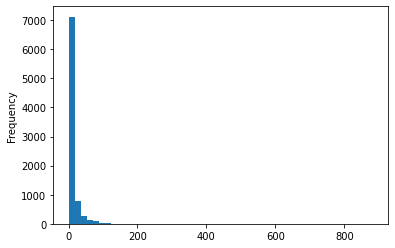

In [ ]:
%matplotlib inline
#Create histogram to find out how many customers purchased item only once.
lf_tx_data['frequency'].plot(kind='hist', bins=50)
print(lf_tx_data['frequency'].describe())
print("---------------------------------------")
one_time_buyers = round(sum(lf_tx_data['frequency'] == 0)/float(len(lf_tx_data))*(100),2)
print("Percentage of customers purchase the item only once:", one_time_buyers ,"%")

We can observe that on an average a customer make 9 repeated purchases

In [ ]:
#Frequency/Recency Analysis Using the BG/NBD Model
from lifetimes import BetaGeoFitter
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(lf_tx_data['frequency'], lf_tx_data['recency'], lf_tx_data['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 8487 subjects, a: 0.43, alpha: 18.77, b: 3.71, r: 0.31>


/usr/local/lib/python3.6/dist-packages/lifetimes/fitters/beta_geo_fitter.py:214: RuntimeWarning: overflow encountered in double_scalars
  ((alpha + T) / (alpha + recency)) ** (r + x)


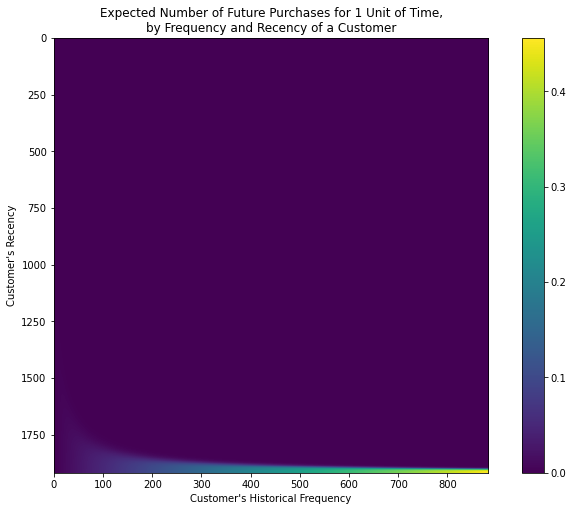

In [ ]:
#Visualizing our frequency/recency matrix
%matplotlib inline
import matplotlib.pyplot as plt
from lifetimes.plotting import plot_frequency_recency_matrix
fig = plt.figure(figsize=(12,8))
plot_frequency_recency_matrix(bgf)

Expected number of transaction each customer can make in the upcoming time period based on age, last purchase, number of transactions he did. The tail shows the customers who purchased recently, but are not frequent customers

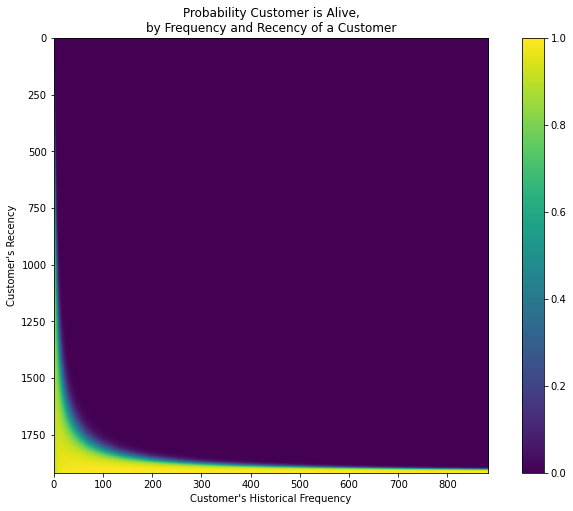

In [ ]:
#predict if the customers are surely alive:
from lifetimes.plotting import plot_probability_alive_matrix
fig = plt.figure(figsize=(12,8))
plot_probability_alive_matrix(bgf)

In [ ]:
#Predict future transaction in next 10 days i.e.top 10 customers that the model expects them to make purchases 
#in the next 10 days, based on historical data

t = 10
lf_tx_data['pred_num_txn'] = round(bgf.conditional_expected_number_of_purchases_up_to_time(t, lf_tx_data['frequency'], lf_tx_data['recency'], lf_tx_data['T']),2)
lf_tx_data.sort_values(by='pred_num_txn', ascending=False).head(10).reset_index()

,CustomerID,frequency,recency,T,monetary_value,pred_num_txn
0,Guest Customer,433.0,739.0,739.0,67.728268,5.70
1,Karen Piero,512.0,1646.0,1651.0,27.482988,3.05
2,Ashley Pentz,185.0,915.0,919.0,28.911351,1.96
3,Ron Pratt,227.0,1319.0,1326.0,50.207665,1.68
4,allen mcgowan,46.0,266.0,267.0,32.759348,1.59
5,Dawn Figueroa,175.0,1117.0,1127.0,34.311486,1.51
6,Denise Van Hill,265.0,1720.0,1731.0,65.900604,1.50
7,Ely Haupt,105.0,738.0,738.0,39.561333,1.38
8,Mark Edgerton,242.0,1801.0,1814.0,82.779711,1.31
9,Jason Dunn,161.0,1236.0,1243.0,75.338012,1.27


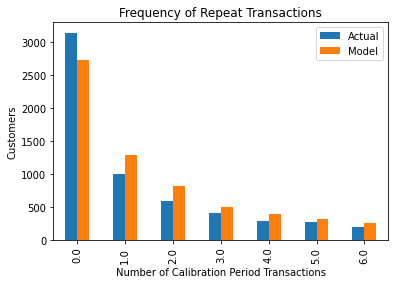

In [ ]:
#Assessing model fit
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

In [ ]:
#Customer's future transaction prediction for next 10 days

t = 10
individual = lf_tx_data.loc["Ashley Pentz"]
bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])

#OBSERVATION: Our model predicts that customer Ashley Pentz future transaction is appx 2 in 10 days.

1.9617775632281995

In [ ]:
#Check if there is correlation between monetary value and frequency in order to use gamma gamma model for CLV calculation.
lf_tx_data[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,0.187902
frequency,0.187902,1.000000


Gamma gamma model keeps an important assumption that there is no significant relationship between monetary value and frequency

In [ ]:
#Shortlist customers who had at least one repeat purchase with the company. 
shortlisted_customers = lf_tx_data[lf_tx_data['frequency']>0]
shortlisted_customers = lf_tx_data[lf_tx_data['monetary_value']>0]
print(shortlisted_customers.head().reset_index())
print("-----------------------------------------")
print("The Number of Returning Customers are: ",len(shortlisted_customers))

           CustomerID  frequency  recency       T  monetary_value  pred_num_txn
0                   A        1.0     43.0   957.0       12.840000          0.00
1       AIMME  SIEGEL        5.0    749.0   816.0       58.800000          0.06
2          AJ HENKELS        8.0    452.0   495.0       58.297500          0.15
3  ALICIA  VALENZUELA       15.0    527.0  1360.0       50.844667          0.00
4    ALYSSA  GONZALEZ        3.0    360.0  1310.0       25.656667          0.00
-----------------------------------------
The Number of Returning Customers are:  5347


In [ ]:
#Train gamma-gamma model by taking into account the monetary_value.
from lifetimes import GammaGammaFitter
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(shortlisted_customers['frequency'],
        shortlisted_customers['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 5347 subjects, p: 1.36, q: 3.87, v: 107.12>


In [ ]:
#After applying Gamma-Gamma model, now we can estimate average transaction value for each customer. 
print(ggf.conditional_expected_average_profit(
        lf_tx_data['frequency'],
        lf_tx_data['monetary_value']
    ).head(10))

CustomerID
A                     38.613211
AIMME  SIEGEL         56.442293
AJ HENKELS            56.744380
ALICIA  VALENZUELA    50.844922
ALYSSA  GONZALEZ      36.048689
AMY  BERSSEN          41.463819
ANDREA  LAWRENCE      78.064745
ANDREA GOMEZ          50.846739
ANGEL CALVO           31.658025
ANITA  LAVIN          50.846739
dtype: float64


In [ ]:
lf_tx_data['pred_txn_value'] = round(ggf.conditional_expected_average_profit(
        lf_tx_data['frequency'],
        lf_tx_data['monetary_value']), 2)
lf_tx_data.reset_index().head()

,CustomerID,frequency,recency,T,monetary_value,pred_num_txn,pred_txn_value
0,A,1.0,43.0,957.0,12.840000,0.00,38.61
1,AIMME SIEGEL,5.0,749.0,816.0,58.800000,0.06,56.44
2,AJ HENKELS,8.0,452.0,495.0,58.297500,0.15,56.74
3,ALICIA VALENZUELA,15.0,527.0,1360.0,50.844667,0.00,50.84
4,ALYSSA GONZALEZ,3.0,360.0,1310.0,25.656667,0.00,36.05


In [ ]:
#Calculate Customer Lifetime Value
lf_tx_data['CLV'] = round(ggf.customer_lifetime_value(
    bgf, #the model to use to predict the number of future transactions
    lf_tx_data['frequency'],
    lf_tx_data['recency'],
    lf_tx_data['T'],
    lf_tx_data['monetary_value'],
    time=12, # months
    discount_rate=0.01 # monthly discount rate ~ 12.7% annually
), 2)

lf_tx_data.drop(lf_tx_data.iloc[:, 0:6], inplace=True, axis=1)

lf_tx_data.sort_values(by='CLV', ascending=False).head(10).reset_index()

,CustomerID,CLV
0,Guest Customer,11985.23
1,Mark Edgerton,3511.48
2,Denise Van Hill,3209.51
3,Jason Dunn,3050.61
4,Ron Lazo,2889.09
5,Karen Piero,2729.98
6,Ron Pratt,2708.08
7,Jodi Smith,2556.39
8,ray miranda,2535.72
9,Haley Matosian,2525.77


In [ ]:
lf_tx_data["CLV"].describe()

count     8487.000000
mean       106.358803
std        288.414364
min          0.000000
25%          3.910000
50%          9.980000
75%         66.425000
max      11985.230000
Name: CLV, dtype: float64

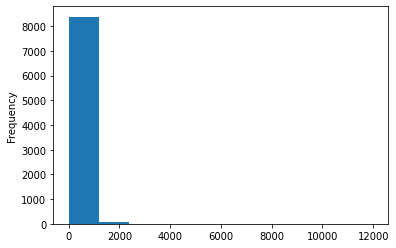

In [ ]:
lf_tx_data["CLV"].plot(kind="hist", bins=10)

In [ ]:
# Marking customers as churned or not based on LTV
#Setting mean as the threshold to consider as churned or not

lf_tx_data["Churn"]="0"

for i in range(len(lf_tx_data["CLV"])):
  if abs(lf_tx_data["CLV"][i])>106.358803:
    lf_tx_data["Churn"][i]="No"
  else: 
    lf_tx_data["Churn"][i]="Yes"


In [ ]:
lf_tx_data.columns

Index(['CLV', 'Churn'], dtype='object')

In [ ]:
lf_tx_data.groupby("Churn")["CLV"].count()

Churn
No     1737
Yes    6750
Name: CLV, dtype: int64

As per the forecast, only 1737 customers of Pets World are likely to remain with the firm after 12 months